Homework 5

UNSUPERVISED LEARNING

Instructions

We will work with a data set that contains transactions for an online retail store based in UK.

The data is available in the UCI repository([Online Retail - UCI Machine Learning
Repository](https://archive.ics.uci.edu/dataset/352/online+retail)).

We are tasked with doing customer segmentation analyses. To that end, we'll
need to apply some clustering algorithms to analyse the data set and see if we can find something interesting.

Therefore, your instructions are the following:

1. Download the data set, read it in Python, and get familiar with it. What are the
columns, descriptive statistics, null counts, value counts, etc. There are approx. 430
customers that are non-UK and 3,950 that are UK-based. There are 8 customers
which have transactions from more than one country. Find, then remove those 8
customers and work with the remaining 4,372.
2. The dataset contains individual transactions, but to do customer segmentation, you'll need to group data by customers. You can group data by customer ID and aggregate individual transaction values (e.g., total amount spent per customer, total items purchased). This step is the data
preprocessing step, so make sure that your grouped data can be fed into a clustering
algorithm.
3. Apply an agglomerative clustering algorithm, use either the implementation from
sklearn or scipy.

  3.1 Try different values for the linkage (sklearn) / method (scipy) parameter.
  Evaluate which one yields the highest Sillhouete score and with that setting, plot a
  dendrogram of the clustering.        
  
4. Apply the KMeans algorithm. Find the optimal value for the parameter k through an
elbow plot), plotting the different values for k on the x-axis (try k = [2,3,4, 5, ... 20] )
and the inertia
_ property on the y-axis. Interpret the plot and state what's the optimal
value for k from the ones tested.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

### What is Customer Segmentation?

Customer segmentation is the process of dividing a company's customer base into distinct groups, or "segments", based on shared characteristics or behaviors. These segments allow businesses to better understand, serve, and target their customers.

This is a widely adopted practice in business and data science, used for:
- Tailored marketing campaigns
- Product recommendations
- Personalized communication
- Customer retention and churn prediction

---

### How is Segmentation Done in Practice?

We generally follow these steps:

1. **Data Collection:** Gather raw transactional data for each customer.
2. **Feature Engineering:** Summarize behavior per customer — e.g., how much they spend, how often they buy, and when they last purchased.
3. **Data Preprocessing:** Handle missing values, normalize numerical features.
4. **Clustering Algorithms:** Use unsupervised learning (e.g., KMeans, Agglomerative Clustering) to find naturally occurring customer groups.
5. **Evaluation & Interpretation:** Measure clustering quality (e.g., Silhouette Score), and interpret each segment (e.g., "high spenders", "loyal buyers", "inactive customers").

---

### Goal of This Analysis

Our task is to perform customer segmentation using historical transaction data from an online retail store. We aim to:
- Group customers by behavior
- Understand different customer types
- Prepare insights that can drive better business decisions

---
#### **My Customer Segmentation Pipeline**

This notebook implements a structured approach to customer segmentation, fully aligned with the assignment requirements:

**1. Load and Explore the Dataset**  
- Load the online retail dataset.  
- Inspect columns, data types, missing values, and value distributions.  
- Filter out 8 customers with transactions from multiple countries to retain a clean set of 4,364 valid UK customers.  

**2. Data Cleaning**  
- **Missing Values:** Removed rows with missing `CustomerID`.  
- **Duplicate Values:** Removed duplicate transactions to ensure accurate customer-level aggregation.  
- **Canceled Invoices:** Identified and excluded canceled transactions to avoid negative impact on clustering results.  
- **Outlier Detection:** Analyzed and removed extreme outliers to improve clustering stability and accuracy.  

**3. Feature Engineering (Data Preprocessing)**  
Aggregated key customer-level features to capture purchase behavior, including:  
- **TotalSpent**: Total amount spent.  
- **Frequency**: Number of unique invoices.  
- **Recency**: Days since the last purchase.  
- **AvgUnitPrice**: Average price per unit purchased.  

**4. Data Transformation**  
- **Log Transformation:** Applied `log1p()` to reduce the impact of extreme values and reduce right-skewness in the following features:  
  - **TotalSpent**  
  - **Frequency**  
  - **Recency**  
  - **AvgUnitPrice**  
- This transformation helps stabilize variance and makes the data more suitable for distance-based algorithms.  

**5. Data Scaling and Dimensionality Reduction**  
- Chose **RobustScaler** to reduce the impact of extreme values, resulting in more balanced clusters.  
- **t-SNE:** Applied **t-Distributed Stochastic Neighbor Embedding (t-SNE)** for visualizing the high-dimensional data in 2D or 3D, allowing for better cluster interpretation and validation.  

**6. Agglomerative Clustering**  
- **Testing Different `n_clusters`:** Evaluated multiple values for the number of clusters to identify the most meaningful segmentation.  
- **Dendrogram:** Generated a dendrogram to visualize the hierarchical structure and assess cluster separation.  
- **Distributions of Recognized Clusters:** Analyzed the size and distribution of the formed clusters to understand the balance and separation.  
- **PCA for Dimensionality Reduction of One Cluster:** Applied **PCA** to reduce the dimensionality of a selected cluster for more focused analysis.  
- **Clustering with PCA Components:** Used the PCA-transformed data for a second round of clustering to verify the stability of the segments.  
- **Analyzing the Characteristics of Each Cluster:** Examined the average spending, frequency, and recency for each cluster to understand customer behavior.  
- **DBSCAN:** Applied **DBSCAN** to further refine sub-clusters within one of the identified clusters, focusing on isolating dense regions and outliers.  

**7. KMeans Clustering**  
- **KneeLocator:** Used **KneeLocator** to determine the optimal number of clusters based on the elbow method (inertia vs. k).  
- **Cluster Analysis:** Analyzed the resulting clusters to understand the key characteristics of each group, including spending patterns, purchase frequency, and recency.  
- **What Can We Learn From These Clusters?** Identified strategic customer groups for personalized marketing, retention campaigns, and potential upselling.  

**8. Summary and Insights**  
- Successfully segmented customers based on their purchasing behavior, revealing meaningful customer groups.  
- Identified key clusters with distinct spending and engagement patterns, including high-value frequent buyers, inactive customers, and one-time purchasers.  
- Demonstrated the effectiveness of dimensionality reduction (PCA) and density-based clustering (DBSCAN) for refining segments.  
- Created a robust clustering pipeline that can be applied to future customer datasets for ongoing segmentation and business analysis.  

---

### 1. Load and Explore the Dataset

In [2]:
#df_raw = pd.read_excel("Online Retail.xlsx")

In [3]:
#df_raw.to_csv("Online_Retail.csv", index=False)

In [5]:
df_raw = pd.read_csv("Online_Retail.csv")

In [6]:
df_raw.sample(7)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
226024,556777,47566,PARTY BUNTING,4,2011-06-14 12:31:00,4.95,14426.0,United Kingdom
360429,568227,84519A,TOMATO CHARLIE+LOLA COASTER SET,1,2011-09-26 10:57:00,1.25,17841.0,United Kingdom
318024,564820,21880,RED RETROSPOT TAPE,1,2011-08-30 12:16:00,0.42,NaN,United Kingdom
294611,562715,22978,PANTRY ROLLING PIN,1,2011-08-08 15:34:00,7.46,NaN,United Kingdom
295561,562792,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2,2011-08-09 14:18:00,2.95,17634.0,United Kingdom
300358,563195,21242,RED RETROSPOT PLATE,2,2011-08-12 16:36:00,3.29,NaN,United Kingdom
309030,564061,82580,BATHROOM METAL SIGN,2,2011-08-22 14:38:00,0.55,14505.0,United Kingdom


In [7]:
pre_working_df = df_raw.copy()

In [8]:
print("Descriptive Statistics")
print("==" * 11)

print("\nDataset shape:", pre_working_df.shape)
print("-" * 24)

print("\nData types:")
print("-" * 23)
print(pre_working_df.dtypes)

print("\nMissing values per column:")
print("-" * 26)
print(pre_working_df.isna().sum())

print("\nNumerical summary:")
print("-" * 18)
display(pre_working_df.describe(include=[np.number]))

print("\nCategorical summary:")
print("-" * 20)
display(pre_working_df.describe(include=[object]))

Descriptive Statistics

Dataset shape: (541909, 8)
------------------------

Data types:
-----------------------
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Missing values per column:
--------------------------
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Numerical summary:
------------------


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000



Categorical summary:
--------------------


,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2011-10-31 14:41:00,United Kingdom
freq,1114,2313,2369,1114,495478


I noticed that the `Quantity` feature contains negative values, which likely represent returns.

In [9]:
unique_customers = pre_working_df["CustomerID"].nunique()
print("Number of unique customers (with ID):", unique_customers)

Number of unique customers (with ID): 4372


Although there are 541,909 transactions in the dataset, they were made by only 4,372 unique customers.

In [10]:
# UK vs non-UK
uk_customers = pre_working_df[pre_working_df["Country"] == "United Kingdom"]["CustomerID"].nunique()
non_uk_customers = pre_working_df[pre_working_df["Country"] != "United Kingdom"]["CustomerID"].nunique()

print(f"UK customers: {uk_customers}")
print(f"Non-UK customers: {non_uk_customers}")

UK customers: 3950
Non-UK customers: 422


In [11]:
country_counts = pre_working_df.groupby("Country")["CustomerID"].nunique().sort_values(ascending=False)
country_counts

Country
United Kingdom          3950
Germany                   95
France                    87
Spain                     31
Belgium                   25
Switzerland               21
Portugal                  19
Italy                     15
Finland                   12
Austria                   11
Norway                    10
Channel Islands            9
Netherlands                9
Australia                  9
Denmark                    9
Cyprus                     8
Japan                      8
Sweden                     8
Poland                     6
Unspecified                4
Canada                     4
USA                        4
Greece                     4
Israel                     4
EIRE                       3
Bahrain                    2
Malta                      2
United Arab Emirates       2
Brazil                     1
Czech Republic             1
Saudi Arabia               1
Lebanon                    1
Iceland                    1
European Community         1
Lithua

In [12]:
customers_by_country = pre_working_df.groupby("CustomerID")["Country"].nunique()
multi_country_customers = customers_by_country[customers_by_country > 1].index.tolist()
print(f"Number of customers with transactions in multiple countries: {len(multi_country_customers)}")

Number of customers with transactions in multiple countries: 8


In [13]:
pre_working_df = pre_working_df[~pre_working_df["CustomerID"].isin(multi_country_customers)].copy()
print("Remaining unique customers:", pre_working_df["CustomerID"].nunique())

Remaining unique customers: 4364


### 2. Clean the Data

#### Missing Values

In [14]:
missing_customer = pre_working_df[pre_working_df["CustomerID"].isna()]
print("Number of rows with missing CustomerID:", missing_customer.shape[0])

display(missing_customer.head())

# Checking if there are negative quantities (possibly returns)
print("Negative quantities among missing CustomerID rows:", (missing_customer["Quantity"] < 0).sum())

# Checking the number of unique InvoiceNo where CustomerID is missing
print("Unique Invoice numbers (missing CustomerID):", missing_customer["InvoiceNo"].nunique())

Number of rows with missing CustomerID: 135080


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


Negative quantities among missing CustomerID rows: 1719
Unique Invoice numbers (missing CustomerID): 3710


In [15]:
num_mixed_invoices = pre_working_df.groupby("InvoiceNo")["CustomerID"].apply(lambda x: x.notna().any() and x.isna().any()).sum()
print("Invoices that appear both with and without CustomerID:", num_mixed_invoices)

Invoices that appear both with and without CustomerID: 0


Rows with missing CustomerID will be removed because I cannot assign those transactions to any specific customer for segmentation.

In [16]:
pre_working_df = pre_working_df[pre_working_df["CustomerID"].notna()].copy()

print("Remaining rows after removing missing CustomerID:", pre_working_df.shape[0])
print("Remaining unique customers:", pre_working_df["CustomerID"].nunique())

Remaining rows after removing missing CustomerID: 405903
Remaining unique customers: 4364


The Description column will be dropped because it contains missing values and is not useful for numerical clustering.

In [17]:
# pre_working_df = pre_working_df.drop("Description", axis=1)

# print("Remaining columns:", pre_working_df.columns.tolist())

#### Duplicate values

In [18]:
print("Original size:", pre_working_df.shape[0])
print("Duplicates:", pre_working_df.duplicated().sum())

Original size: 405903
Duplicates: 5223


In [19]:
pre_working_df[pre_working_df.duplicated(keep=False)].sort_values(by=list(pre_working_df.columns))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
...,...,...,...,...,...,...,...,...
440149,C574510,22360,GLASS JAR ENGLISH CONFECTIONERY,-1,2011-11-04 13:25:00,2.95,15110.0,United Kingdom
461407,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,2011-11-13 11:38:00,0.55,17838.0,United Kingdom
461408,C575940,23309,SET OF 60 I LOVE LONDON CAKE CASES,-24,2011-11-13 11:38:00,0.55,17838.0,United Kingdom
529980,C580764,22667,RECIPE BOX RETROSPOT,-12,2011-12-06 10:38:00,2.95,14562.0,United Kingdom


In [20]:
pre_working_df_cleaned = pre_working_df.drop_duplicates().reset_index(drop=True)

In [21]:
print("Cleaned size:", pre_working_df_cleaned.shape[0])

Cleaned size: 400680


---

In [22]:
pre_working_cleaned = pre_working_df_cleaned.copy()

In [23]:
len(pre_working_cleaned)

400680

#### Canceled Invoices

There are invoices starting with the letter **"C"**, which indicate canceled or returned transactions. These invoices, along with their matching positive records, need to be removed from the dataset. This is essential because they do not represent actual purchases and could distort customer segmentation analysis. Including such entries would introduce noise and potentially misrepresent customer behavior.

In [24]:
cancelled_invoices = pre_working_cleaned[pre_working_cleaned["InvoiceNo"].str.startswith("C")].copy()
original_invoices = pre_working_cleaned[~pre_working_cleaned["InvoiceNo"].str.startswith("C")].copy()

In [25]:
# Converting the InvoiceDate into datetime
pre_working_cleaned["InvoiceDate"] = pd.to_datetime(pre_working_cleaned["InvoiceDate"])
cancelled_invoices["InvoiceDate"] = pd.to_datetime(cancelled_invoices["InvoiceDate"])

# Finding exact Match Pairs
exact_match_pairs = pd.merge(
    cancelled_invoices.groupby(["StockCode", "CustomerID", "UnitPrice", "Description"]).agg({"Quantity": "sum"}).reset_index(),
    original_invoices.groupby(["StockCode", "CustomerID", "UnitPrice", "Description"]).agg({"Quantity": "sum"}).reset_index(),
    on=["StockCode", "CustomerID", "UnitPrice", "Description"],
    suffixes=("_canc", "_orig")
)

exact_match_pairs = exact_match_pairs[exact_match_pairs["Quantity_canc"] == -exact_match_pairs["Quantity_orig"]]

In [26]:
# Removing exact match pairs
indexes_to_drop = []

for _, row in exact_match_pairs.iterrows():

    canc_index = cancelled_invoices[
        (cancelled_invoices["StockCode"] == row["StockCode"]) &
        (cancelled_invoices["CustomerID"] == row["CustomerID"]) &
        (cancelled_invoices["UnitPrice"] == row["UnitPrice"]) &
        (cancelled_invoices["Description"] == row["Description"])
    ].index[0]
    
    indexes_to_drop.append(canc_index)
    
    potential_matches = original_invoices[
        (original_invoices["StockCode"] == row["StockCode"]) &
        (original_invoices["CustomerID"] == row["CustomerID"]) &
        (original_invoices["UnitPrice"] == row["UnitPrice"]) &
        (original_invoices["Description"] == row["Description"])
    ].sort_values(by="InvoiceDate")
    
    if not potential_matches.empty:
        orig_index = potential_matches.index[0]
        indexes_to_drop.append(orig_index)

pre_working_cleaned.drop(index=indexes_to_drop, inplace=True)
pre_working_cleaned.reset_index(drop=True, inplace=True)

print(f"Deleted {len(indexes_to_drop)} exact match pairs (1649 returns + 1649 originals).")

Deleted 3298 exact match pairs (1649 returns + 1649 originals).


In [27]:
len(pre_working_cleaned)

397382

In [28]:
len(cancelled_invoices)

8857

In [29]:
# remaining canceled and original invoices
remaining_cancelled_invoices = pre_working_cleaned[pre_working_cleaned["InvoiceNo"].astype(str).str.startswith("C")].copy()
remaining_original_invoices = pre_working_cleaned[~pre_working_cleaned["InvoiceNo"].astype(str).str.startswith("C")].copy()

In [30]:
len(remaining_cancelled_invoices)

7208

In [31]:
# Grouping by StockCode, CustomerID, UnitPrice, and Description
canc_grouped = remaining_cancelled_invoices.groupby(["StockCode", "CustomerID", "UnitPrice", "Description"]).agg({"Quantity": "sum"}).reset_index()
orig_grouped = remaining_original_invoices.groupby(["StockCode", "CustomerID", "UnitPrice", "Description"]).agg({"Quantity": "sum"}).reset_index()

# Merging to find partial matches
partial_match_pairs = pd.merge(
    canc_grouped,
    orig_grouped,
    on=["StockCode", "CustomerID", "UnitPrice", "Description"],
    suffixes=("_canc", "_orig")
)

# Filtering for partial returns (negative cancellations with smaller absolute values)
valid_partial_matches = partial_match_pairs[
    (partial_match_pairs["Quantity_canc"] < 0) &
    (partial_match_pairs["Quantity_orig"] > abs(partial_match_pairs["Quantity_canc"]))
]

In [32]:
# correction map for efficient partial match adjustment
correction_map = valid_partial_matches.set_index(["StockCode", "CustomerID", "UnitPrice", "Description"])[["Quantity_canc"]].to_dict()["Quantity_canc"]

In [33]:
len(valid_partial_matches)

5053

In [34]:
# Check for remaining negative quantities without "C" in the invoice number
remaining_negatives = pre_working_cleaned[
    (pre_working_cleaned["Quantity"] < 0) &
    (~pre_working_cleaned["InvoiceNo"].astype(str).str.startswith("C"))
]

# Return the number of remaining problematic rows and corrected record count
remaining_negatives.shape[0], valid_partial_matches.shape[0]

(0, 5053)

In [35]:
# Apply the corrections in a single pass
pre_working_cleaned["Correction"] = pre_working_cleaned.apply(
    lambda row: row["Quantity"] + correction_map.get((row["StockCode"], row["CustomerID"], row["UnitPrice"], row["Description"]), 0)
    if (row["StockCode"], row["CustomerID"], row["UnitPrice"], row["Description"]) in correction_map and row["Quantity"] >= abs(correction_map[(row["StockCode"], row["CustomerID"], row["UnitPrice"], row["Description"])])
    else row["Quantity"],
    axis=1
)

# Updating the main quantity column
pre_working_cleaned["Quantity"] = pre_working_cleaned["Correction"]
pre_working_cleaned.drop(columns=["Correction"], inplace=True)

After correcting exact and partial matches, it is important to fully remove any remaining canceled invoices. These invoices, identified by InvoiceNo values starting with "C", should be completely excluded from the dataset to prevent further data distortion.

In [36]:
pre_working_cleaned = pre_working_cleaned[~pre_working_cleaned["InvoiceNo"].astype(str).str.startswith("C")].copy()

print("Remaining rows after removing canceled invoices:", pre_working_cleaned.shape[0])

Remaining rows after removing canceled invoices: 390174


#### Basic Data Summary

In [37]:
pre_working_cleaned[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,390174.000000,390174.000000
mean,12.399419,3.014655
std,45.687021,12.461541
min,0.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,12540.000000,4161.060000


I noticed that the **Quantity** and **UnitPrice** columns contain **0** as their minimum values, which indicates potential data entry errors. Additionally, **Quantity** has an unusually high maximum value (**12540**), suggesting the presence of extreme outliers which I will investigate latter.

To address this:
- I will **remove** all rows with **Quantity** equal to **0**, as they likely indicate data errors or invalid transactions.
- For **UnitPrice**, I will **impute** the most common (modal) price for each product, based on its **StockCode**, to ensure more accurate pricing.

In [38]:
pre_working_cleaned = pre_working_cleaned[pre_working_cleaned["Quantity"] > 0].copy()

print("Remaining rows after removing zero quantities:", pre_working_cleaned.shape[0])

Remaining rows after removing zero quantities: 387093


In [39]:
# Extracting StockCodes with zero UnitPrice
zero_price_stockcodes = pre_working_cleaned[pre_working_cleaned["UnitPrice"] == 0]["StockCode"].unique()

# dictionary of the most common prices for each StockCode
modal_price_dict = pre_working_cleaned[
    (pre_working_cleaned["UnitPrice"] > 0) &
    (pre_working_cleaned["StockCode"].isin(zero_price_stockcodes))
].groupby("StockCode")["UnitPrice"].apply(lambda x: x.mode().iloc[0]).to_dict()

print(modal_price_dict)

{'21208': 0.39, '21786': 0.42, '22055': 1.65, '22062': 0.83, '22065': 0.39, '22089': 2.95, '22090': 2.95, '22162': 2.95, '22167': 9.95, '22168': 8.5, '22423': 12.75, '22437': 0.85, '22464': 1.65, '22553': 1.65, '22580': 5.95, '22619': 3.75, '22625': 8.5, '22778': 3.95, '22841': 7.95, '22899': 2.1, '22955': 2.1, '22960': 4.25, '23157': 2.08, '23234': 2.89, '23268': 1.45, '23270': 1.45, '23407': 9.95, '23480': 3.75, '47566': 4.95, '84535B': 0.65, '84826': 0.85, 'M': 1.25, 'PADS': 0.001}


In [40]:
# Replacing zero prices using the modal price dictionary
pre_working_cleaned.loc[
    pre_working_cleaned["StockCode"].isin(modal_price_dict.keys()) &
    (pre_working_cleaned["UnitPrice"] == 0),
    "UnitPrice"
] = pre_working_cleaned["StockCode"].map(modal_price_dict)

# Checking if all zero prices are replaced
remaining_zero_prices_final = pre_working_cleaned[pre_working_cleaned["UnitPrice"] == 0]

print("Remaining zero price records:", remaining_zero_prices_final.shape[0])

Remaining zero price records: 0


In [41]:
pre_working_cleaned[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,387093.000000,387093.000000
mean,12.498110,2.993094
std,45.855033,12.477047
min,1.000000,0.001000
25%,2.000000,1.250000
50%,6.000000,1.950000
75%,12.000000,3.750000
max,12540.000000,4161.060000


#### Outlier Detection

In [42]:
# Isolation Forest for Outlier Detection
random_state = 42

numeric_features = pre_working_cleaned.select_dtypes(include=["number"])

In [43]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=random_state)

In [44]:
pre_working_cleaned["anomaly_label"] = iso_forest.fit_predict(numeric_features)

In [45]:
inliers_df = pre_working_cleaned[pre_working_cleaned["anomaly_label"] == 1].drop(columns=["anomaly_label"]).reset_index(drop=True)
outliers_df = pre_working_cleaned[pre_working_cleaned["anomaly_label"] == -1].drop(columns=["anomaly_label"]).reset_index(drop=True)

In [46]:
print(f"Total Records: {len(pre_working_cleaned)}")
print(f"Inliers: {len(inliers_df)} ({len(inliers_df) / len(pre_working_cleaned) * 100:.2f}%)")
print(f"Outliers: {len(outliers_df)} ({len(outliers_df) / len(pre_working_cleaned) * 100:.2f}%)")

Total Records: 387093
Inliers: 383222 (99.00%)
Outliers: 3871 (1.00%)


In [47]:
inliers_df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,383222.000000,383222.000000
mean,10.098374,2.813533
std,15.665982,2.825148
min,1.000000,0.001000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,200.000000,85.000000


In [48]:
outliers_df[["Quantity", "UnitPrice"]].describe()

,Quantity,UnitPrice
count,3871.000000,3871.000000
mean,250.067683,20.769272
std,359.154015,120.257026
min,1.000000,0.040000
25%,100.000000,0.640000
50%,200.000000,1.650000
75%,288.000000,4.950000
max,12540.000000,4161.060000


### 3. Feature Engineering (Data Preprocessing Step)

In [49]:
working_df = inliers_df[["CustomerID", "Quantity", "UnitPrice", "InvoiceDate", "InvoiceNo"]].copy()

print("Columns in working_df:", working_df.columns)
print("Number of records:", working_df.shape[0])

Columns in working_df: Index(['CustomerID', 'Quantity', 'UnitPrice', 'InvoiceDate', 'InvoiceNo'], dtype='object')
Number of records: 383222


In [50]:
categorical_features = working_df.select_dtypes(include="object").columns.tolist()
numerical_features = working_df.select_dtypes(exclude="object").columns.tolist()

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

Categorical Features: ['InvoiceNo']
Numerical Features: ['CustomerID', 'Quantity', 'UnitPrice', 'InvoiceDate']


#### Feature Classification

| Feature         | Type        | Subtype       | Explanation                                                                 |
|----------------|-------------|---------------|------------------------------------------------------------------------------|
| `InvoiceNo`     | Categorical | Nominal       | Unique invoice code – identifier without intrinsic order                    |                         |
| `Quantity`      | Numerical   | Ratio         | Can be zero or negative, true zero has meaning                              |
| `InvoiceDate`   | Datetime    | -             | Timestamp of purchase – needed for recency feature                          |
| `UnitPrice`     | Numerical   | Ratio         | 0 means item was free; true zero makes sense                                |
| `CustomerID`    | Numerical   | Identifier    | Unique customer code – treated as ID, not a true numerical feature          |


#### Customer Spending

In [51]:
working_df["TotalSpent"] = working_df["Quantity"] * working_df["UnitPrice"]

In [52]:
total_spent = working_df.groupby("CustomerID")["TotalSpent"].sum()
total_spent.head()

CustomerID
12347.0    4060.40
12348.0     835.08
12349.0    1417.60
12350.0     294.40
12352.0    1125.28
Name: TotalSpent, dtype: float64

#### Frequency

In [53]:
working_df_freq = working_df.groupby("CustomerID")["InvoiceNo"].nunique()

#### Recency

In [54]:
working_df["InvoiceDate"] = pd.to_datetime(working_df["InvoiceDate"])
reference_date = working_df["InvoiceDate"].max() + pd.Timedelta(days=1)
working_df_recency = working_df.groupby("CustomerID")["InvoiceDate"].max().apply(lambda x: (reference_date - x).days)

#### Average Unit Price per customer

In [55]:
working_df_avg_price = working_df.groupby("CustomerID")["UnitPrice"].mean()

In [56]:
final_df = pd.DataFrame({
    "TotalSpent": total_spent,
    "Frequency": working_df_freq,
    "Recency": working_df_recency,
    "AvgUnitPrice": working_df_avg_price
})

These features summarize customer activity and will serve as the foundation for segmentation using clustering algorithms.

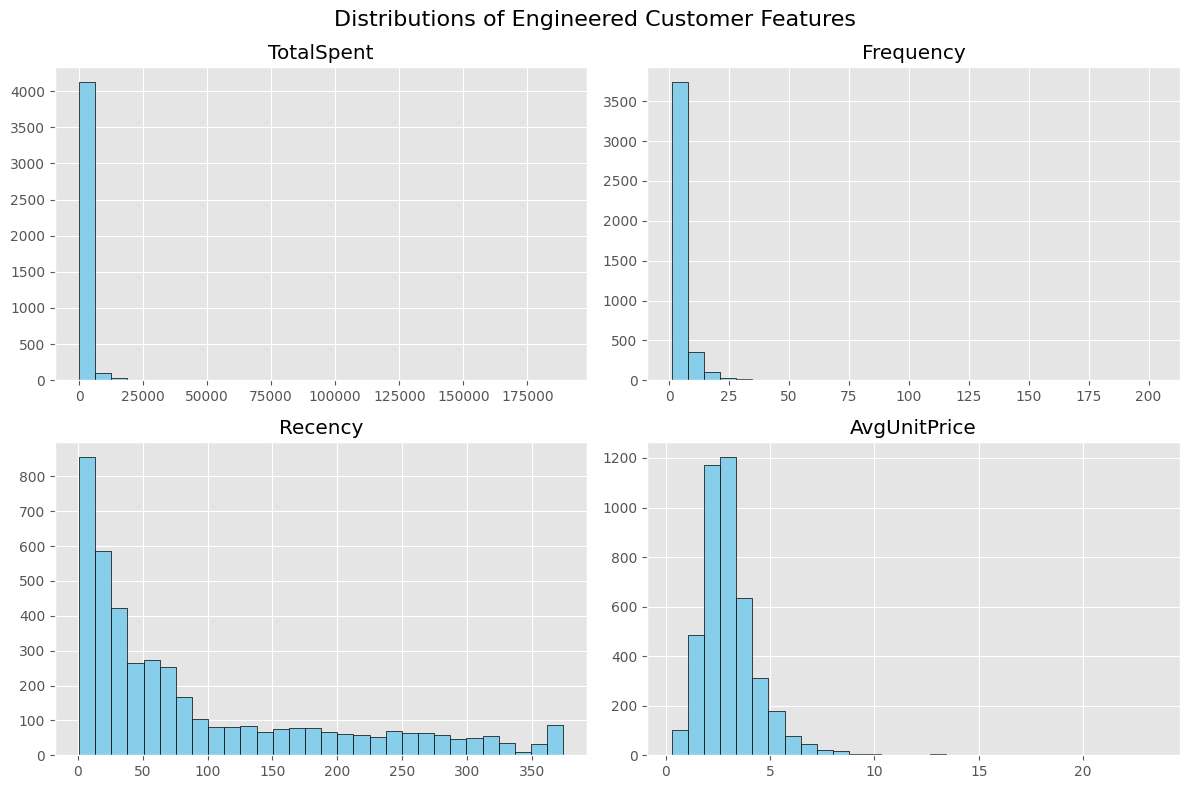

In [57]:
plt.style.use("ggplot")

features = ["TotalSpent", "Frequency", "Recency", "AvgUnitPrice"]
final_df[features].hist(bins=30, figsize=(12, 8), color="skyblue", edgecolor="black")
plt.suptitle("Distributions of Engineered Customer Features", fontsize=16)
plt.tight_layout()
plt.show()

Since all four engineered features (TotalSpent, Frequency, Recency, AvgUnitPrice) have highly skewed distributions, a log transformation will be applied first to reduce the impact of extreme values and bring the distributions closer to normal. After the transformation, I will use a Scaler to ensure that all features contribute equally to the clustering algorithm.

### 4. Data Transformation

In [60]:
transformed_df = final_df.copy()
transformed_df["TotalSpent"] = np.log1p(transformed_df["TotalSpent"])
transformed_df["Frequency"] = np.log1p(transformed_df["Frequency"])
transformed_df["Recency"] = np.log1p(transformed_df["Recency"])
transformed_df["AvgUnitPrice"] = np.log1p(transformed_df["AvgUnitPrice"])

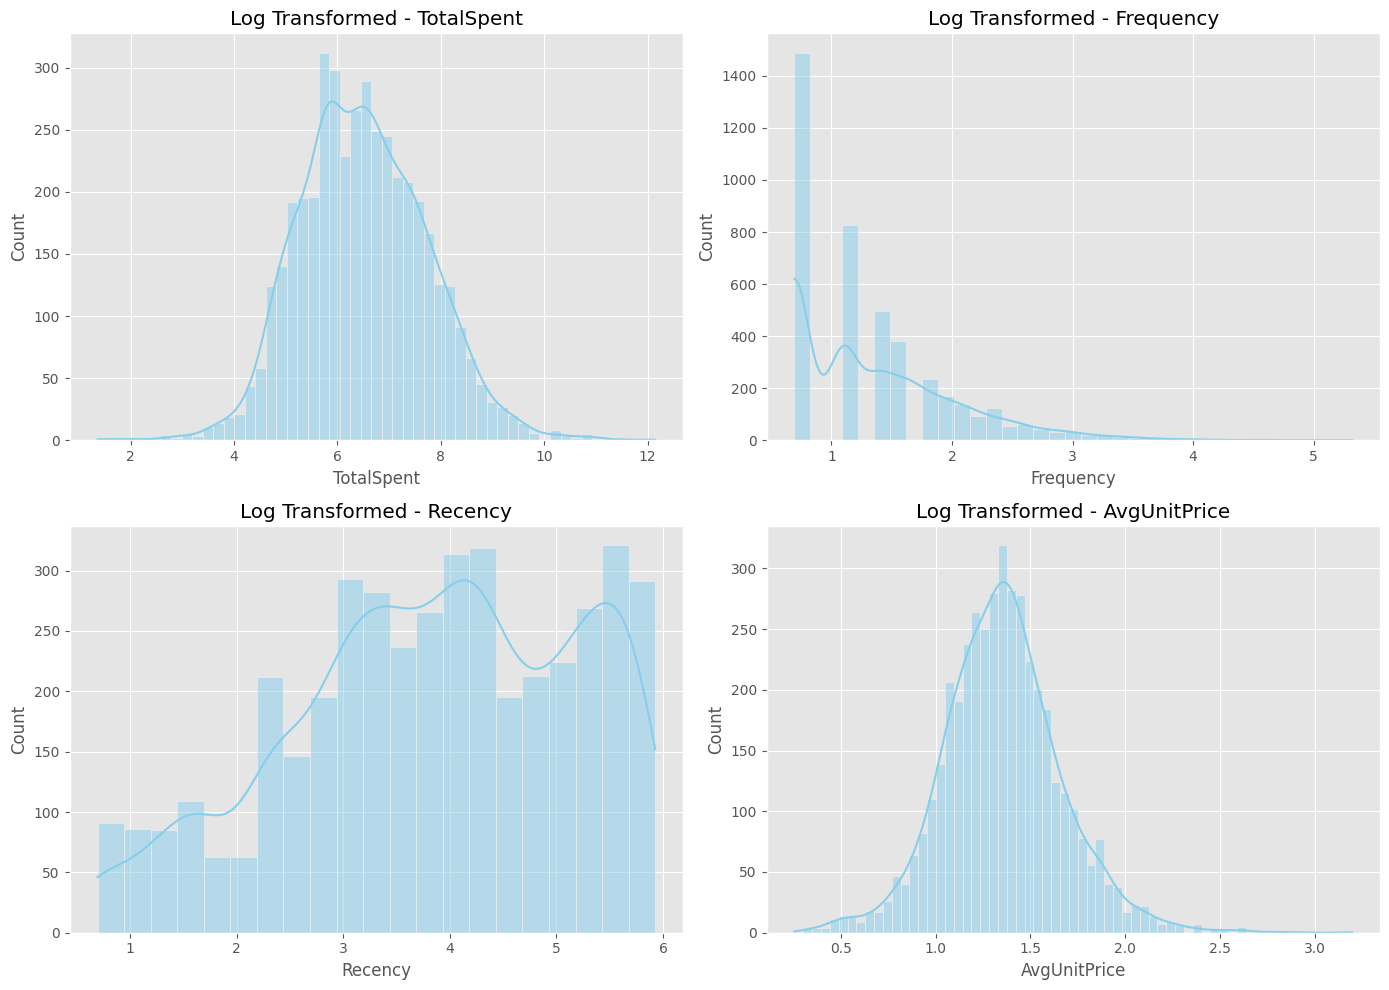

In [61]:
plt.figure(figsize=(14, 10))

for i, col in enumerate(transformed_df.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(transformed_df[col], kde=True, color="skyblue")
    plt.title(f"Log Transformed - {col}")

plt.tight_layout()
plt.show()

Now that the distributions are better, the next step is to scale the features to ensure they all contribute equally to the clustering distance calculations.

### 5. Data Scaling

In [62]:
# Standard Scaling
scaled_df_standard = transformed_df.copy()

scaler_standard = StandardScaler()
scaled_features_standard = scaler_standard.fit_transform(scaled_df_standard)

scaled_df_standard = pd.DataFrame(scaled_features_standard, columns=transformed_df.columns)

scaled_df_standard.describe()

,TotalSpent,Frequency,Recency,AvgUnitPrice
count,4.274000e+03,4.274000e+03,4.274000e+03,4.274000e+03
mean,3.524452e-16,3.408078e-17,2.078096e-16,-3.258455e-16
std,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00
min,-4.177305e+00,-9.516939e-01,-2.341173e+00,-3.488267e+00
25%,-6.748477e-01,-9.516939e-01,-6.629678e-01,-6.219550e-01
50%,-4.193061e-02,-3.516573e-01,8.754573e-02,-2.119009e-02
75%,6.771886e-01,6.741121e-01,8.519880e-01,5.873646e-01
max,4.590237e+00,5.892676e+00,1.560300e+00,5.861927e+00


In [63]:
# RobustScaler
scaled_df_robust = transformed_df.copy()

scaler_robust = RobustScaler()
scaled_features_robust = scaler_robust.fit_transform(scaled_df_robust)

scaled_df_robust = pd.DataFrame(scaled_features_robust, columns=transformed_df.columns)

scaled_df_robust.describe()

,TotalSpent,Frequency,Recency,AvgUnitPrice
count,4274.000000,4274.000000,4274.000000,4.274000e+03
mean,0.031013,0.216297,-0.057788,1.752233e-02
std,0.739712,0.615152,0.660163,8.270080e-01
min,-3.058627,-0.369070,-1.603161,-2.866965e+00
25%,-0.468121,-0.369070,-0.495403,-4.967793e-01
50%,0.000000,0.000000,0.000000,-2.916775e-16
75%,0.531879,0.630930,0.504597,5.032207e-01
max,3.426067,3.840761,0.972144,4.864815e+00


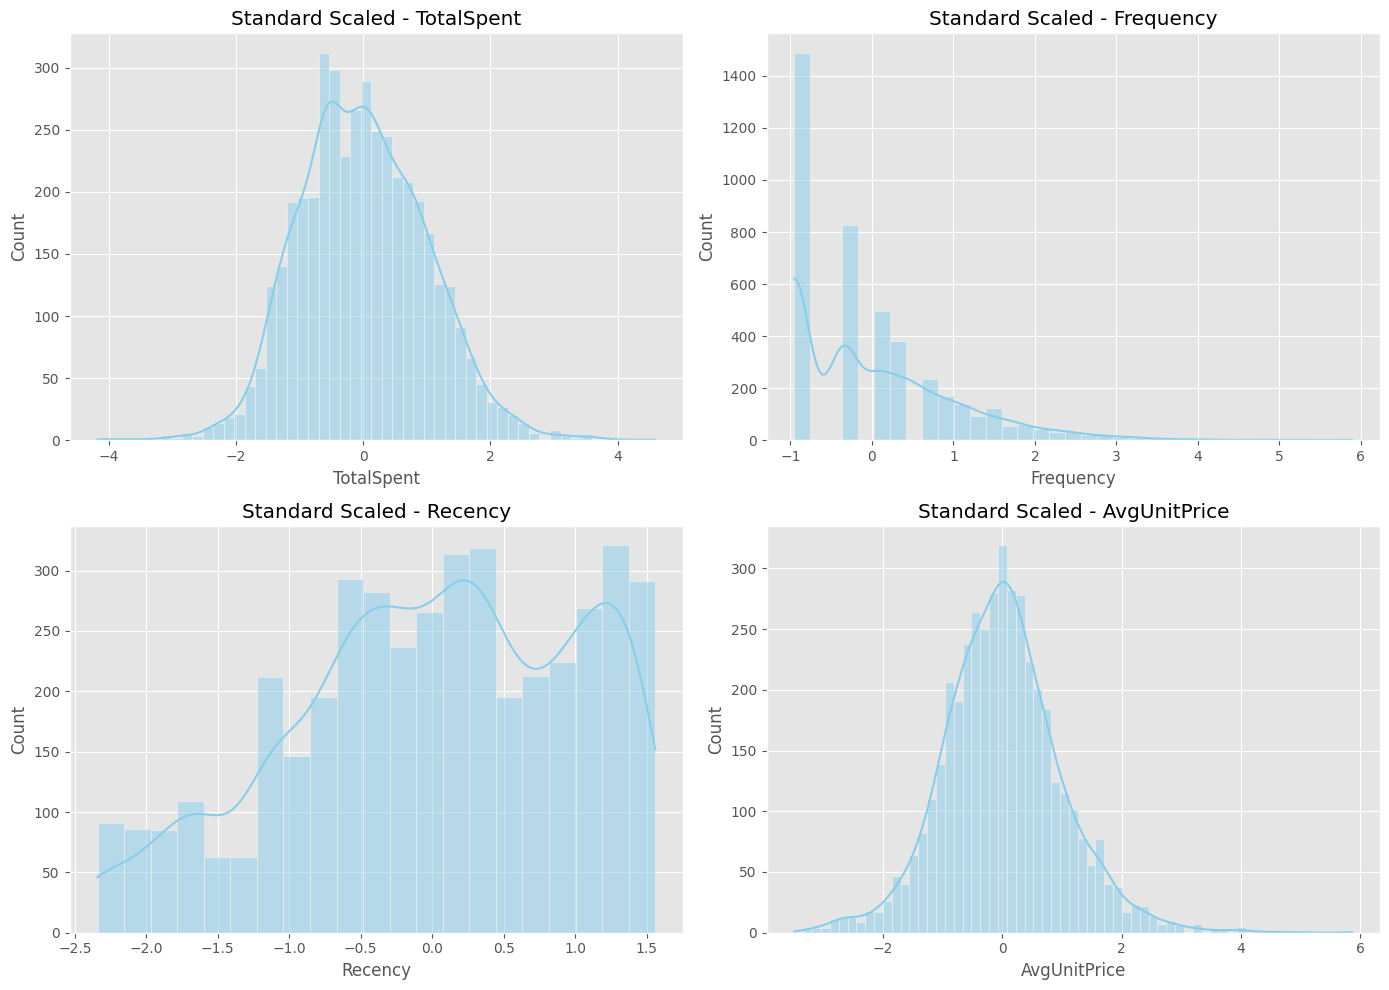

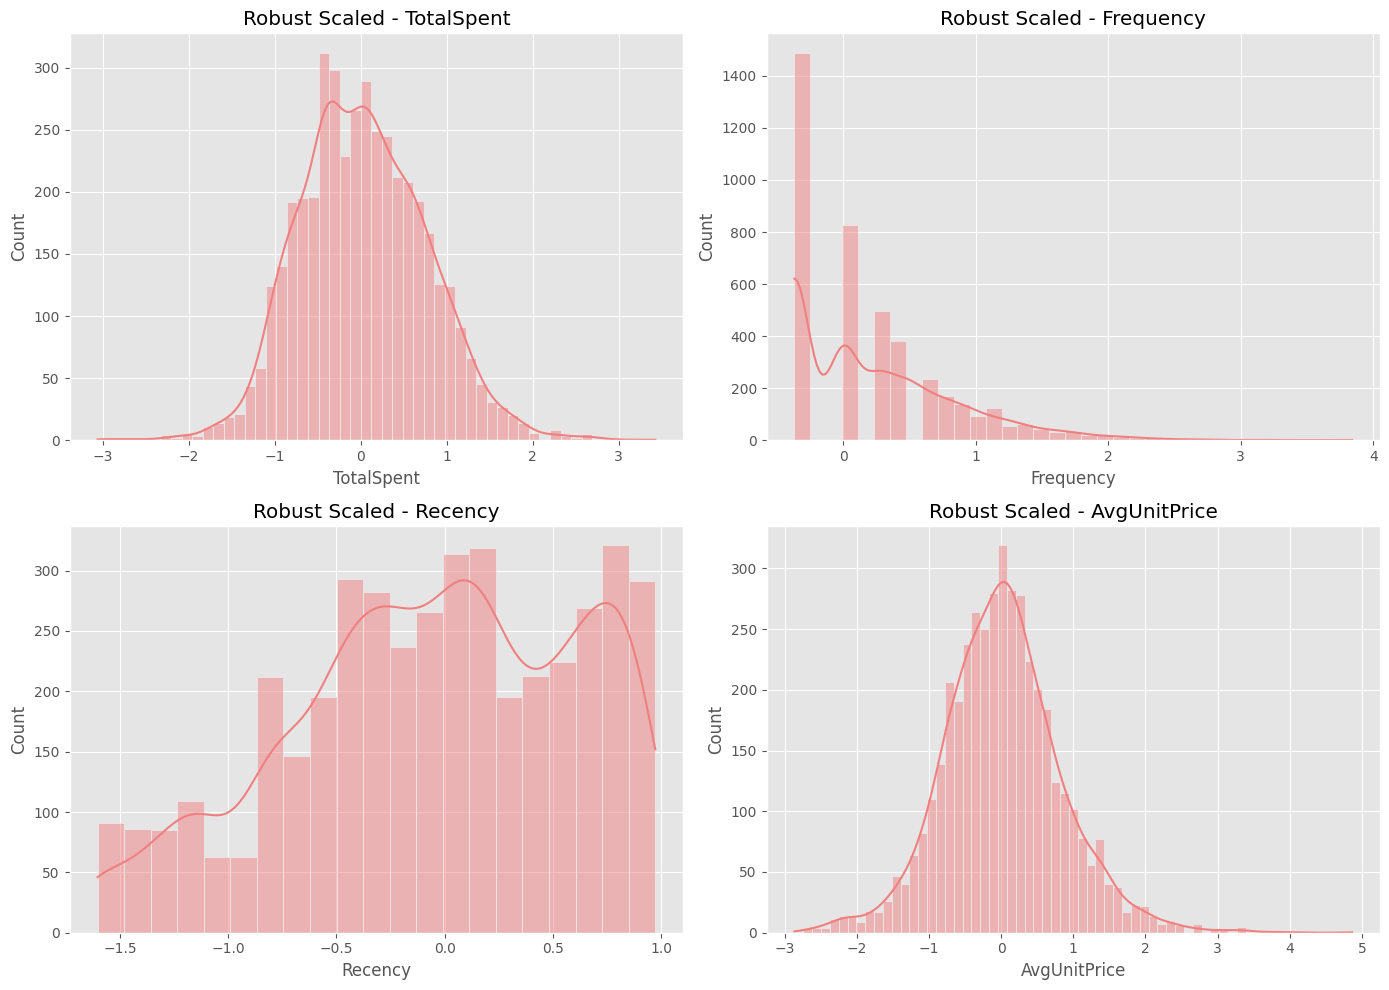

In [64]:
# Plot Standard Scaled data
plt.figure(figsize=(14, 10))
for i, col in enumerate(scaled_df_standard.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(scaled_df_standard[col], kde=True, color="skyblue")
    plt.title(f"Standard Scaled - {col}")

plt.tight_layout()
plt.show()

# Plot Robust Scaled data
plt.figure(figsize=(14, 10))
for i, col in enumerate(scaled_df_robust.columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(scaled_df_robust[col], kde=True, color="lightcoral")
    plt.title(f"Robust Scaled - {col}")

plt.tight_layout()
plt.show()

I will choose **RobustScaler** for feature scaling because it reduces the impact of extreme values, resulting in more balanced clusters, which is especially important given the right-skewed distributions in **TotalSpent** and **Frequency**.

#### Applying t-SNE to the scaled data

In [65]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(scaled_df_robust)

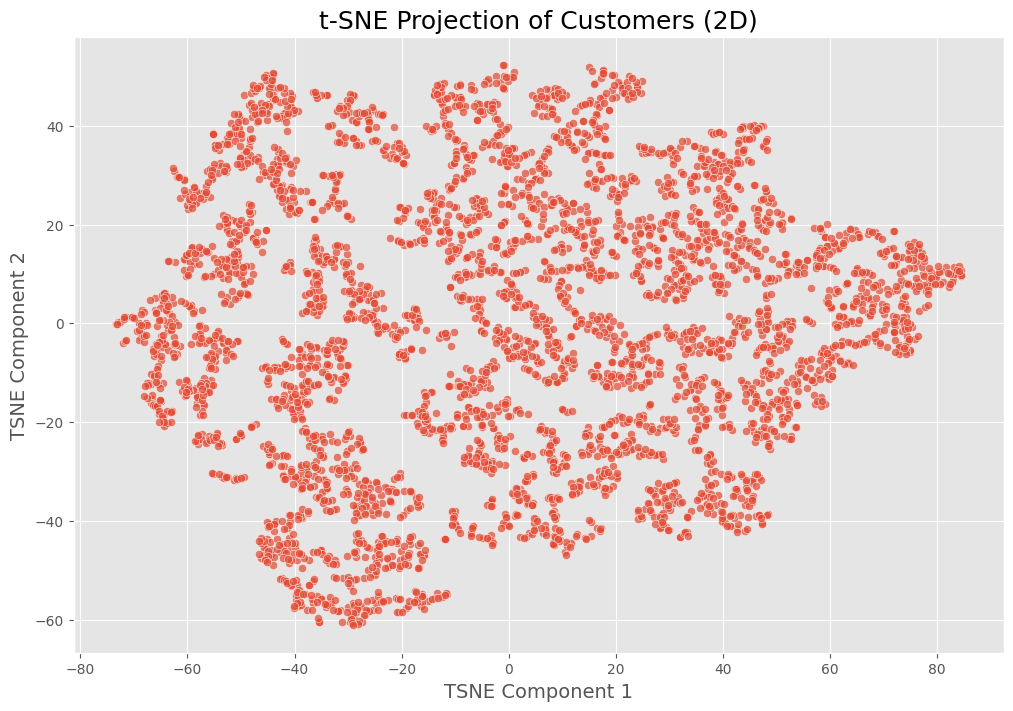

In [66]:
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE_1", "TSNE_2"])

plt.figure(figsize=(12, 8))
sns.scatterplot(x="TSNE_1", y="TSNE_2", data=tsne_df, alpha=0.7)
plt.title("t-SNE Projection of Customers (2D)", fontsize=18)
plt.xlabel("TSNE Component 1", fontsize=14)
plt.ylabel("TSNE Component 2", fontsize=14)
plt.grid(True)
plt.show()

The t-SNE 2D projection reveals a more complex, non-linear structure in the customer data, suggesting potential subclusters within the overall distribution. 

I initially planned to experiment with t-SNE in more detail, testing different **perplexity** and **learning rate** combinations, but it required too much computation time, so I will proceed with Agglomerative Clustering, followed by PCA, and then decide if DBSCAN is necessary before finalizing with K-Means.

### 6. Agglomerative Clustering

In [67]:
X = scaled_df_robust.copy()

#### Testing different n_clusters

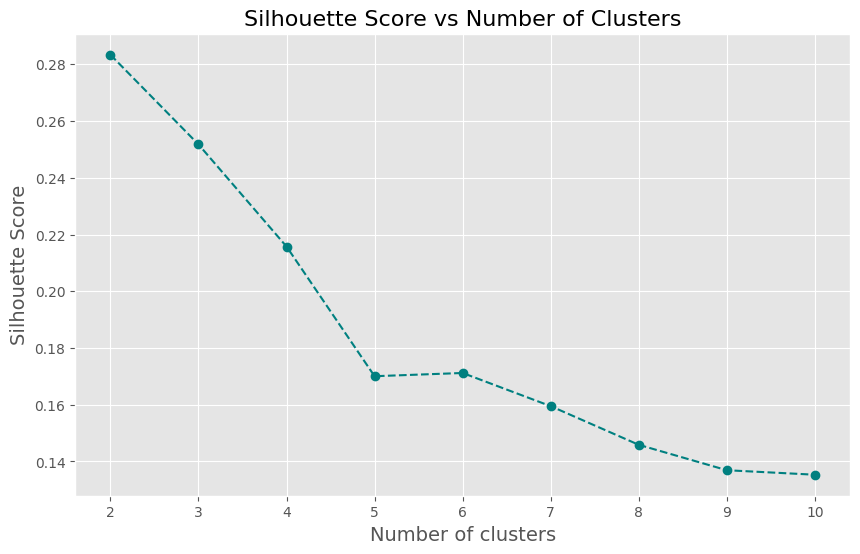

Optimal number of clusters: 2 with Silhouette Score: 0.2834


In [68]:
range_n = range(2, 11)
sil_scores = []

for n in range_n:
    model = AgglomerativeClustering(n_clusters=n, linkage="ward")
    labels = model.fit_predict(X)
    score = silhouette_score(X, labels)

    if len(set(labels)) > 1:
        score = silhouette_score(X, labels)
    else:
        score = -1  # Invalid silhouette score for single cluster
    
    sil_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range_n, sil_scores, marker="o", linestyle="--", color="teal")
plt.title("Silhouette Score vs Number of Clusters", fontsize=16)
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.grid(True)
plt.show()

optimal_clusters = range_n[np.argmax(sil_scores)]
print(f"Optimal number of clusters: {optimal_clusters} with Silhouette Score: {max(sil_scores):.4f}")

Although the highest Silhouette Score was achieved with 2 clusters, I will proceed with 3 clusters to better capture the distinct behaviors of VIP customers with high spending, as well as the majority of regular customers.

In [69]:
linkage_methods = ["ward", "average", "complete", "single"]
distance_metrics = ["euclidean", "manhattan", "cosine"]
scores = {}

for method in linkage_methods:
    for metric in distance_metrics:
        if method == "ward" and metric != "euclidean":
            continue
        
        model = AgglomerativeClustering(n_clusters=3, linkage=method, metric=metric if method != "ward" else "euclidean")
        labels = model.fit_predict(X)
        
        if len(set(labels)) > 1:
            score = silhouette_score(X, labels)
            scores[(method, metric)] = score
        else:
            scores[(method, metric)] = -1

print("Silhouette Scores by linkage method and distance metric:")
for (method, metric), score in scores.items():
    print(f"{method} + {metric}: {score:.4f}")

Silhouette Scores by linkage method and distance metric:
ward + euclidean: 0.2518
average + euclidean: 0.4198
average + manhattan: 0.3592
average + cosine: 0.2508
complete + euclidean: 0.1883
complete + manhattan: 0.2143
complete + cosine: 0.1132
single + euclidean: 0.3118
single + manhattan: 0.3118
single + cosine: -0.2832



Best combination: average + euclidean


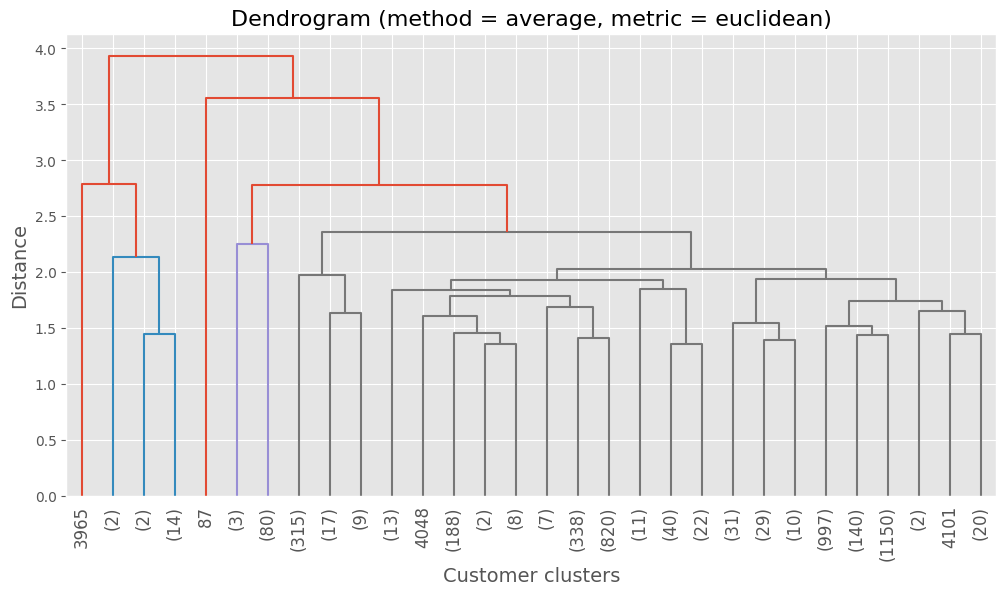

In [71]:
best_combination = max(scores, key=scores.get)
best_method, best_metric = best_combination
print(f"\nBest combination: {best_method} + {best_metric}")

if best_metric == "manhattan":
    distance_matrix = pdist(X, metric="cityblock")
elif best_metric == "cosine":
    distance_matrix = pdist(X, metric="cosine")
else:
    distance_matrix = pdist(X, metric=best_metric)

linkage_matrix = linkage(distance_matrix, method=best_method)

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode="lastp", p=30, leaf_rotation=90, leaf_font_size=12)
plt.title(f"Dendrogram (method = {best_method}, metric = {best_metric})", fontsize=16)
plt.xlabel("Customer clusters", fontsize=14)
plt.ylabel("Distance", fontsize=14)
plt.show()

Since the dendrogram clearly indicates hierarchical structures, the next step is to cut the tree at an optimal height to form distinct customer clusters for further analysis.

In [72]:
num_clusters = 3

cluster_labels = fcluster(linkage_matrix, num_clusters, criterion="maxclust")

clustered_df = scaled_df_robust.copy()
clustered_df["Cluster"] = cluster_labels

cluster_counts = clustered_df["Cluster"].value_counts().sort_index()
print("\nCluster Distribution:")
print(cluster_counts)

cluster_summary = clustered_df.groupby("Cluster").agg({
    "TotalSpent": ["mean", "median", "std", "min", "max"],
    "Frequency": ["mean", "median", "std", "min", "max"],
    "Recency": ["mean", "median", "std", "min", "max"],
    "AvgUnitPrice": ["mean", "median", "std", "min", "max"]
})

cluster_summary


Cluster Distribution:
Cluster
1      19
2    4254
3       1
Name: count, dtype: int64


TotalSpent                                         Frequency  \
              mean    median       std       min       max      mean   
Cluster                                                                
1         2.326153  2.384788  0.541924  1.169159  3.426067  2.819009   
2         0.020677 -0.004124  0.724454 -3.058627  2.846503  0.204488   
3         0.391462  0.391462       NaN  0.391462  0.391462  1.000000   

                                                  Recency                      \
           median       std       min       max      mean    median       std   
Cluster                                                                         
1        2.680144  0.501462  2.095903  3.840761 -1.137777 -1.262095  0.644261   
2        0.000000  0.590406 -0.369070  2.578902 -0.052798  0.000000  0.656319   
3        1.000000       NaN  1.000000  1.000000 -0.764332 -0.764332       NaN   

                            AvgUnitPrice                                \
              min       max         mean    median       std       min   
Cluster                                                                  
1       -1.603161  0.969512    -0.143476 -0.234648  0.634057 -1.109578   
2       -1.603161  0.972144     0.017501  0.001396  0.826442 -2.866965   
3       -0.764332 -0.764332     3.168582  3.168582       NaN  3.168582   

                   
              max  
Cluster            
1        1.461038  
2        4.864815  
3        3.168582

Looking for the characteristics of the customers in each claster.

In [73]:
cluster_1_customers = clustered_df[clustered_df["Cluster"] == 1]
cluster_2_customers = clustered_df[clustered_df["Cluster"] == 2]
cluster_3_customer = clustered_df[clustered_df["Cluster"] == 3]

print("\nCluster 1 Customers:")
display(cluster_1_customers.describe())

print("\nCluster 2 Customers:")
display(cluster_2_customers.describe())

print("\nCluster 3 Customer:")
display(cluster_3_customer)


Cluster 1 Customers:


,TotalSpent,Frequency,Recency,AvgUnitPrice,Cluster
count,19.000000,19.000000,19.000000,19.000000,19.0
mean,2.326153,2.819009,-1.137777,-0.143476,1.0
std,0.541924,0.501462,0.644261,0.634057,0.0
min,1.169159,2.095903,-1.603161,-1.109578,1.0
25%,2.095792,2.514137,-1.603161,-0.348141,1.0
50%,2.384788,2.680144,-1.262095,-0.234648,1.0
75%,2.630702,3.125697,-1.152296,-0.100661,1.0
max,3.426067,3.840761,0.969512,1.461038,1.0



Cluster 2 Customers:


,TotalSpent,Frequency,Recency,AvgUnitPrice,Cluster
count,4254.000000,4254.000000,4254.000000,4254.000000,4254.0
mean,0.020677,0.204488,-0.052798,0.017501,2.0
std,0.724454,0.590406,0.656319,0.826442,0.0
min,-3.058627,-0.369070,-1.603161,-2.866965,2.0
25%,-0.470253,-0.369070,-0.495403,-0.496986,2.0
50%,-0.004124,0.000000,0.000000,0.001396,2.0
75%,0.526571,0.464974,0.507979,0.504508,2.0
max,2.846503,2.578902,0.972144,4.864815,2.0



Cluster 3 Customer:


,TotalSpent,Frequency,Recency,AvgUnitPrice,Cluster
87,0.391462,1.0,-0.764332,3.168582,3


While Cluster 3 contains only a single customer with highly distinct purchasing behavior and Cluster 1 represents a small group of high-frequency, moderate-spending customers, the majority of customers fall into Cluster 2, indicating a dominant segment with more standardized purchasing patterns. This distribution suggests the need for further analysis to better understand the diversity of customer behaviors within these clusters.

#### Distribution of Features for Cluster 1

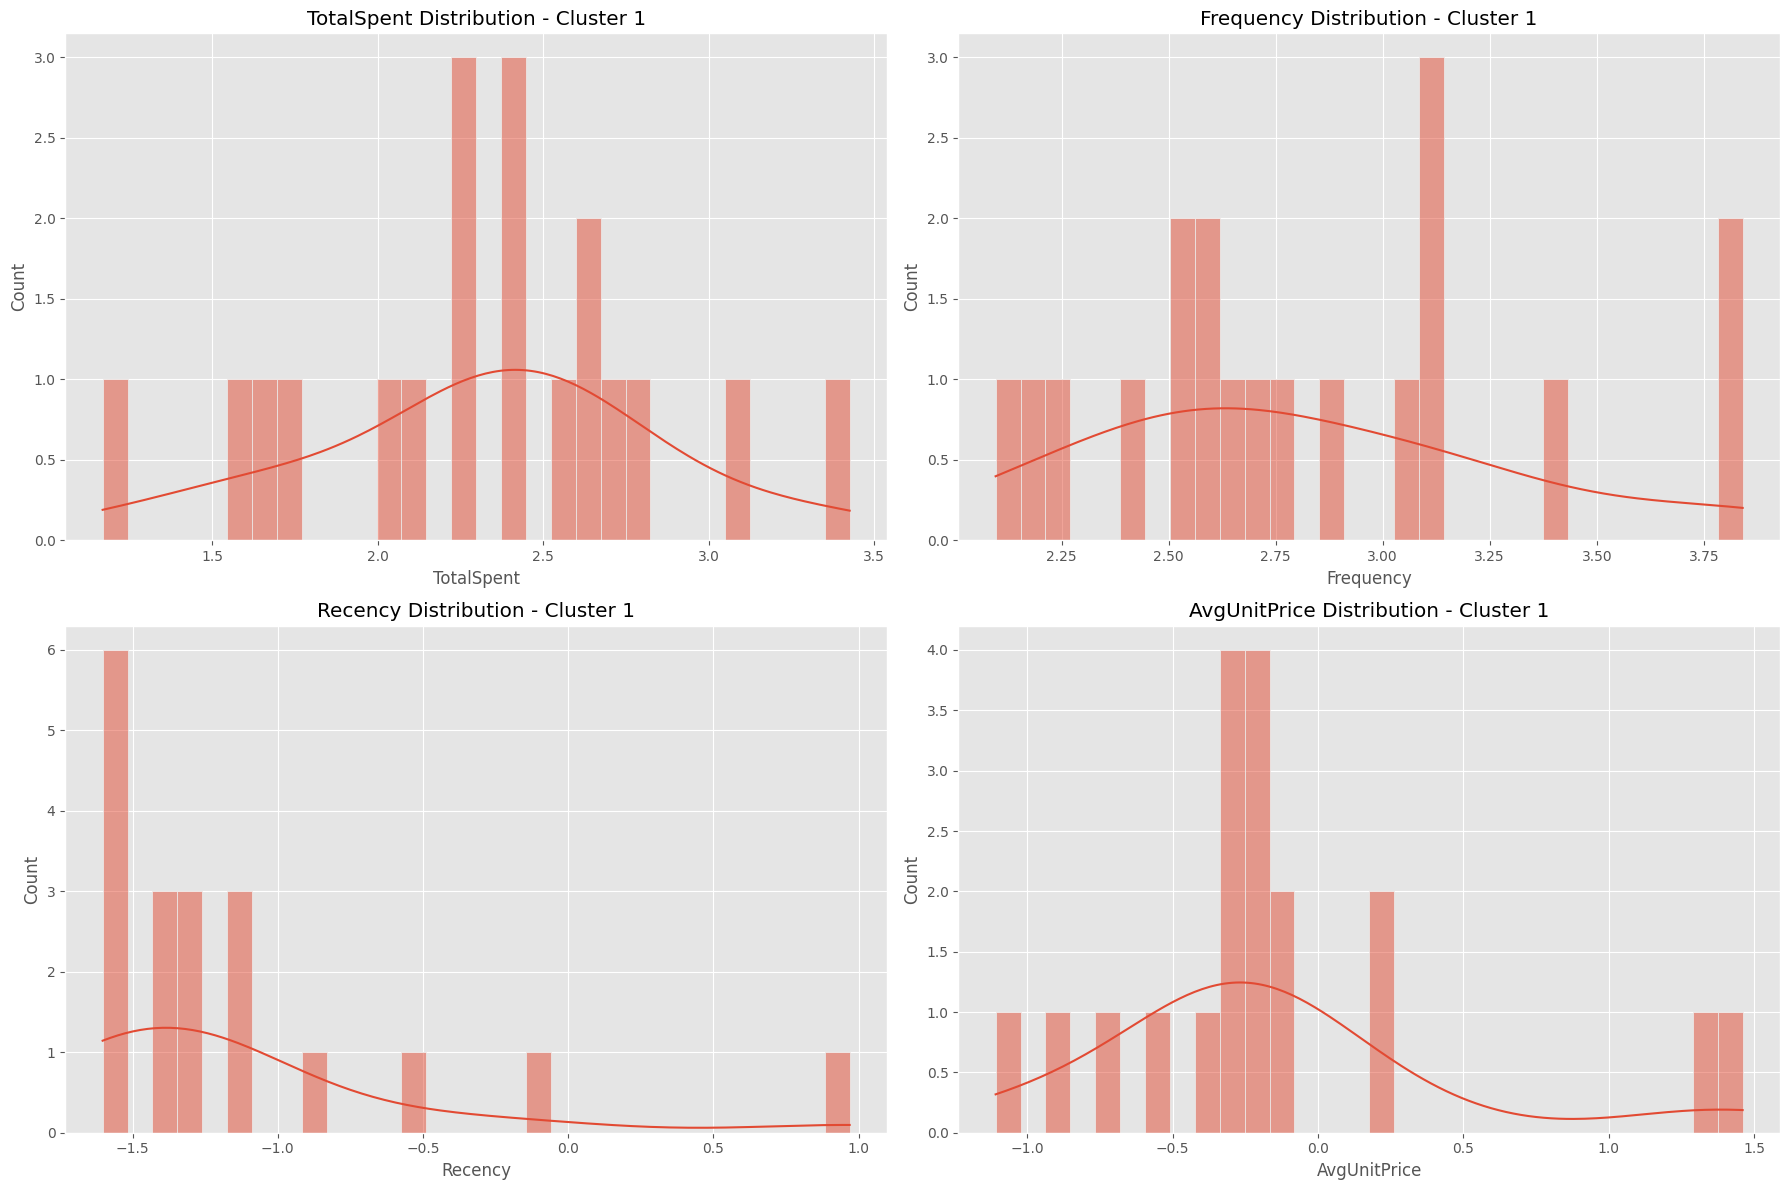

In [74]:
plt.figure(figsize=(18, 12))

# TotalSpent distribution
plt.subplot(2, 2, 1)
sns.histplot(cluster_1_customers["TotalSpent"], bins=30, kde=True)
plt.title("TotalSpent Distribution - Cluster 1")

# Frequency distribution
plt.subplot(2, 2, 2)
sns.histplot(cluster_1_customers["Frequency"], bins=30, kde=True)
plt.title("Frequency Distribution - Cluster 1")

# Recency distribution
plt.subplot(2, 2, 3)
sns.histplot(cluster_1_customers["Recency"], bins=30, kde=True)
plt.title("Recency Distribution - Cluster 1")

# AvgUnitPrice distribution
plt.subplot(2, 2, 4)
sns.histplot(cluster_1_customers["AvgUnitPrice"], bins=30, kde=True)
plt.title("AvgUnitPrice Distribution - Cluster 1")

plt.tight_layout()
plt.show()

Customers in Cluster 1 are characterized by high frequency and moderate spending, with relatively recent purchases. This group likely includes loyal or regular buyers who make frequent transactions but do not necessarily have the highest average unit price. Given their recent activity and consistent purchasing behavior, this segment may be ideal for loyalty programs or personalized promotions to further increase their lifetime value.

#### Distribution of Features for Cluster 2

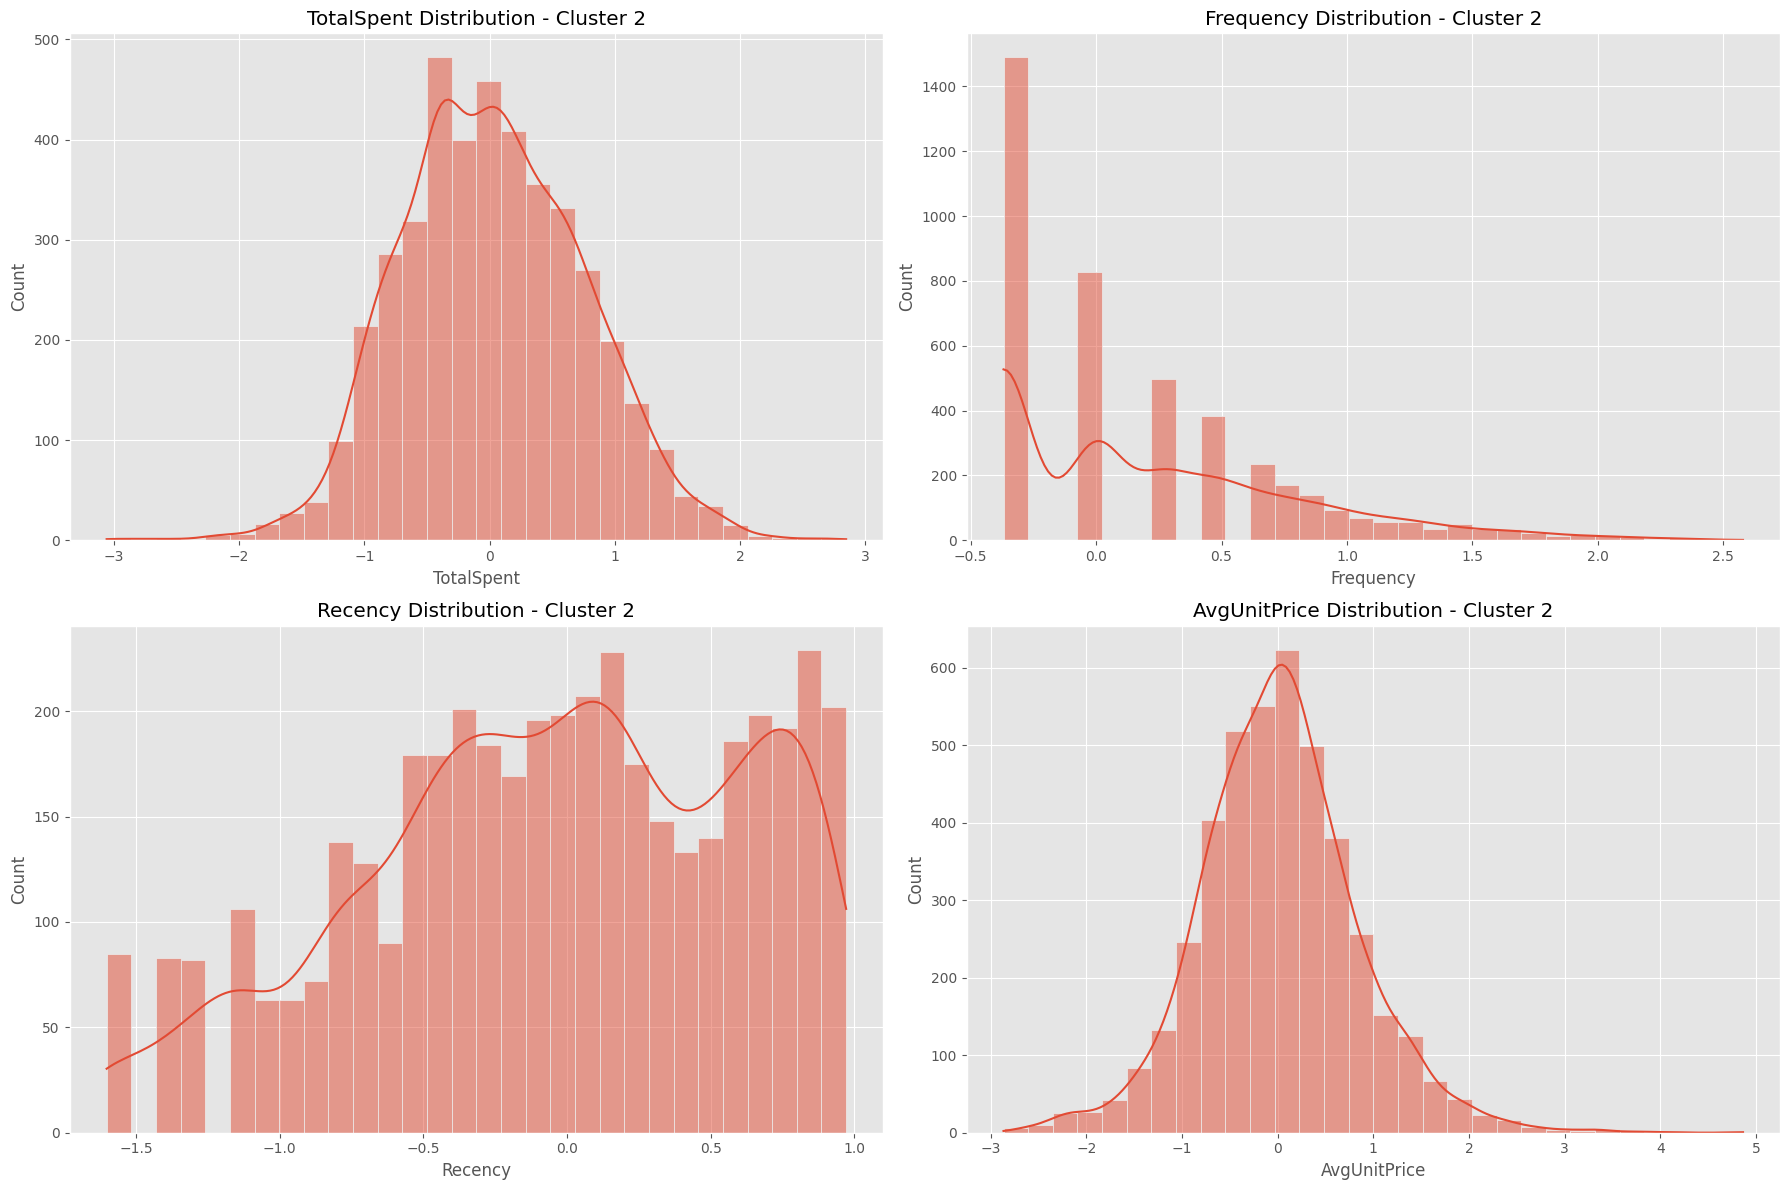

In [75]:
plt.figure(figsize=(18, 12))

# TotalSpent distribution
plt.subplot(2, 2, 1)
sns.histplot(cluster_2_customers["TotalSpent"], bins=30, kde=True)
plt.title("TotalSpent Distribution - Cluster 2")

# Frequency distribution
plt.subplot(2, 2, 2)
sns.histplot(cluster_2_customers["Frequency"], bins=30, kde=True)
plt.title("Frequency Distribution - Cluster 2")

# Recency distribution
plt.subplot(2, 2, 3)
sns.histplot(cluster_2_customers["Recency"], bins=30, kde=True)
plt.title("Recency Distribution - Cluster 2")

# AvgUnitPrice distribution
plt.subplot(2, 2, 4)
sns.histplot(cluster_2_customers["AvgUnitPrice"], bins=30, kde=True)
plt.title("AvgUnitPrice Distribution - Cluster 2")

plt.tight_layout()
plt.show()

Cluster 2 contains the majority of customers, characterized by a wide range of spending levels and lower purchase frequency, indicating a diverse group of less engaged buyers.

To further explore the hidden subgroups within this dominant Cluster 2, I will apply PCA to reduce dimensionality before attempting more precise clustering with DBSCAN.

####  PCA for Dimensionality Reduction

In [76]:
cluster_2_df = clustered_df[clustered_df["Cluster"] == 2].drop("Cluster", axis=1)

In [77]:
pca = PCA(n_components=2, random_state=42)
X_pca_cluster_2 = pca.fit_transform(cluster_2_df)

In [78]:
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio (First 2 Components): {explained_variance}")
print(f"Total Variance Explained: {sum(explained_variance) * 100:.2f}%")

Explained Variance Ratio (First 2 Components): [0.49324211 0.34453926]
Total Variance Explained: 83.78%


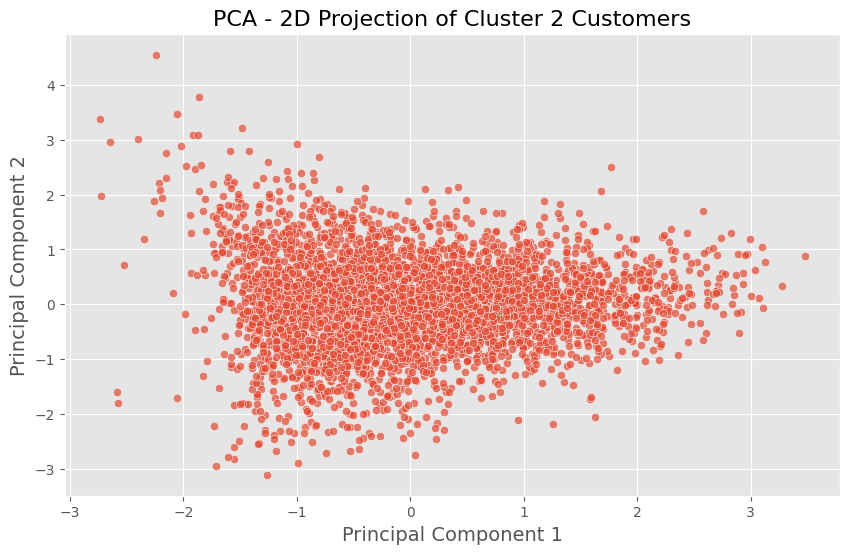

In [79]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca_cluster_2[:, 0], y=X_pca_cluster_2[:, 1], alpha=0.7)
plt.title("PCA - 2D Projection of Cluster 2 Customers", fontsize=16)
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)
plt.show()

The PCA transformation for Cluster 2 successfully reduced the data to two principal components, capturing 83.78% of the total variance, providing a compact representation for further clustering analysis.

#### Clustering with PCA Components

In [80]:
range_n = range(2, 11)
sil_scores = []

for n in range_n:
    model = AgglomerativeClustering(n_clusters=n, linkage="average", metric="euclidean")
    labels = model.fit_predict(X_pca_cluster_2)

    if len(set(labels)) > 1:
        score = silhouette_score(X_pca_cluster_2, labels)
        sil_scores.append(score)
    else:
        sil_scores.append(-1)

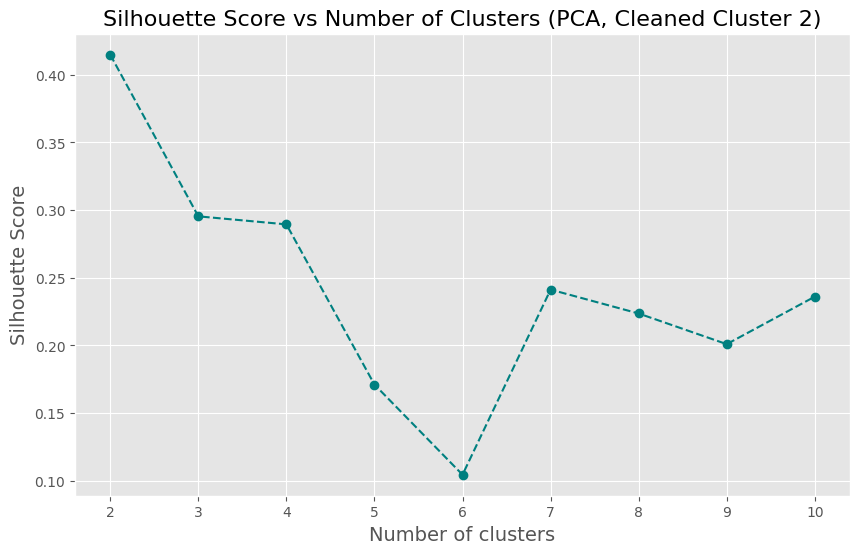

Optimal number of clusters: 2 with Silhouette Score: 0.4148


In [81]:
plt.figure(figsize=(10, 6))
plt.plot(range_n, sil_scores, marker="o", linestyle="--", color="teal")
plt.title("Silhouette Score vs Number of Clusters (PCA, Cleaned Cluster 2)", fontsize=16)
plt.xlabel("Number of clusters", fontsize=14)
plt.ylabel("Silhouette Score", fontsize=14)
plt.xticks(range_n)  # Ensure each cluster number is shown
plt.grid(True)
plt.show()

optimal_clusters = range_n[sil_scores.index(max(sil_scores))]
print(f"Optimal number of clusters: {optimal_clusters} with Silhouette Score: {max(sil_scores):.4f}")

Although the initial analysis suggested 2 clusters as the optimal choice, I will also test 3 to 8 cluster configurations to capture potential subgroups and uncover more nuanced customer segments.

In [83]:
cluster_models = {
    "3 Clusters": AgglomerativeClustering(n_clusters=3, linkage="average", metric="euclidean"),
    "4 Clusters": AgglomerativeClustering(n_clusters=4, linkage="average", metric="euclidean"),
    "5 Clusters": AgglomerativeClustering(n_clusters=5, linkage="average", metric="euclidean"),
    "6 Clusters": AgglomerativeClustering(n_clusters=6, linkage="average", metric="euclidean"),
    "7 Clusters": AgglomerativeClustering(n_clusters=7, linkage="average", metric="euclidean"),
    "8 Clusters": AgglomerativeClustering(n_clusters=8, linkage="average", metric="euclidean")
}

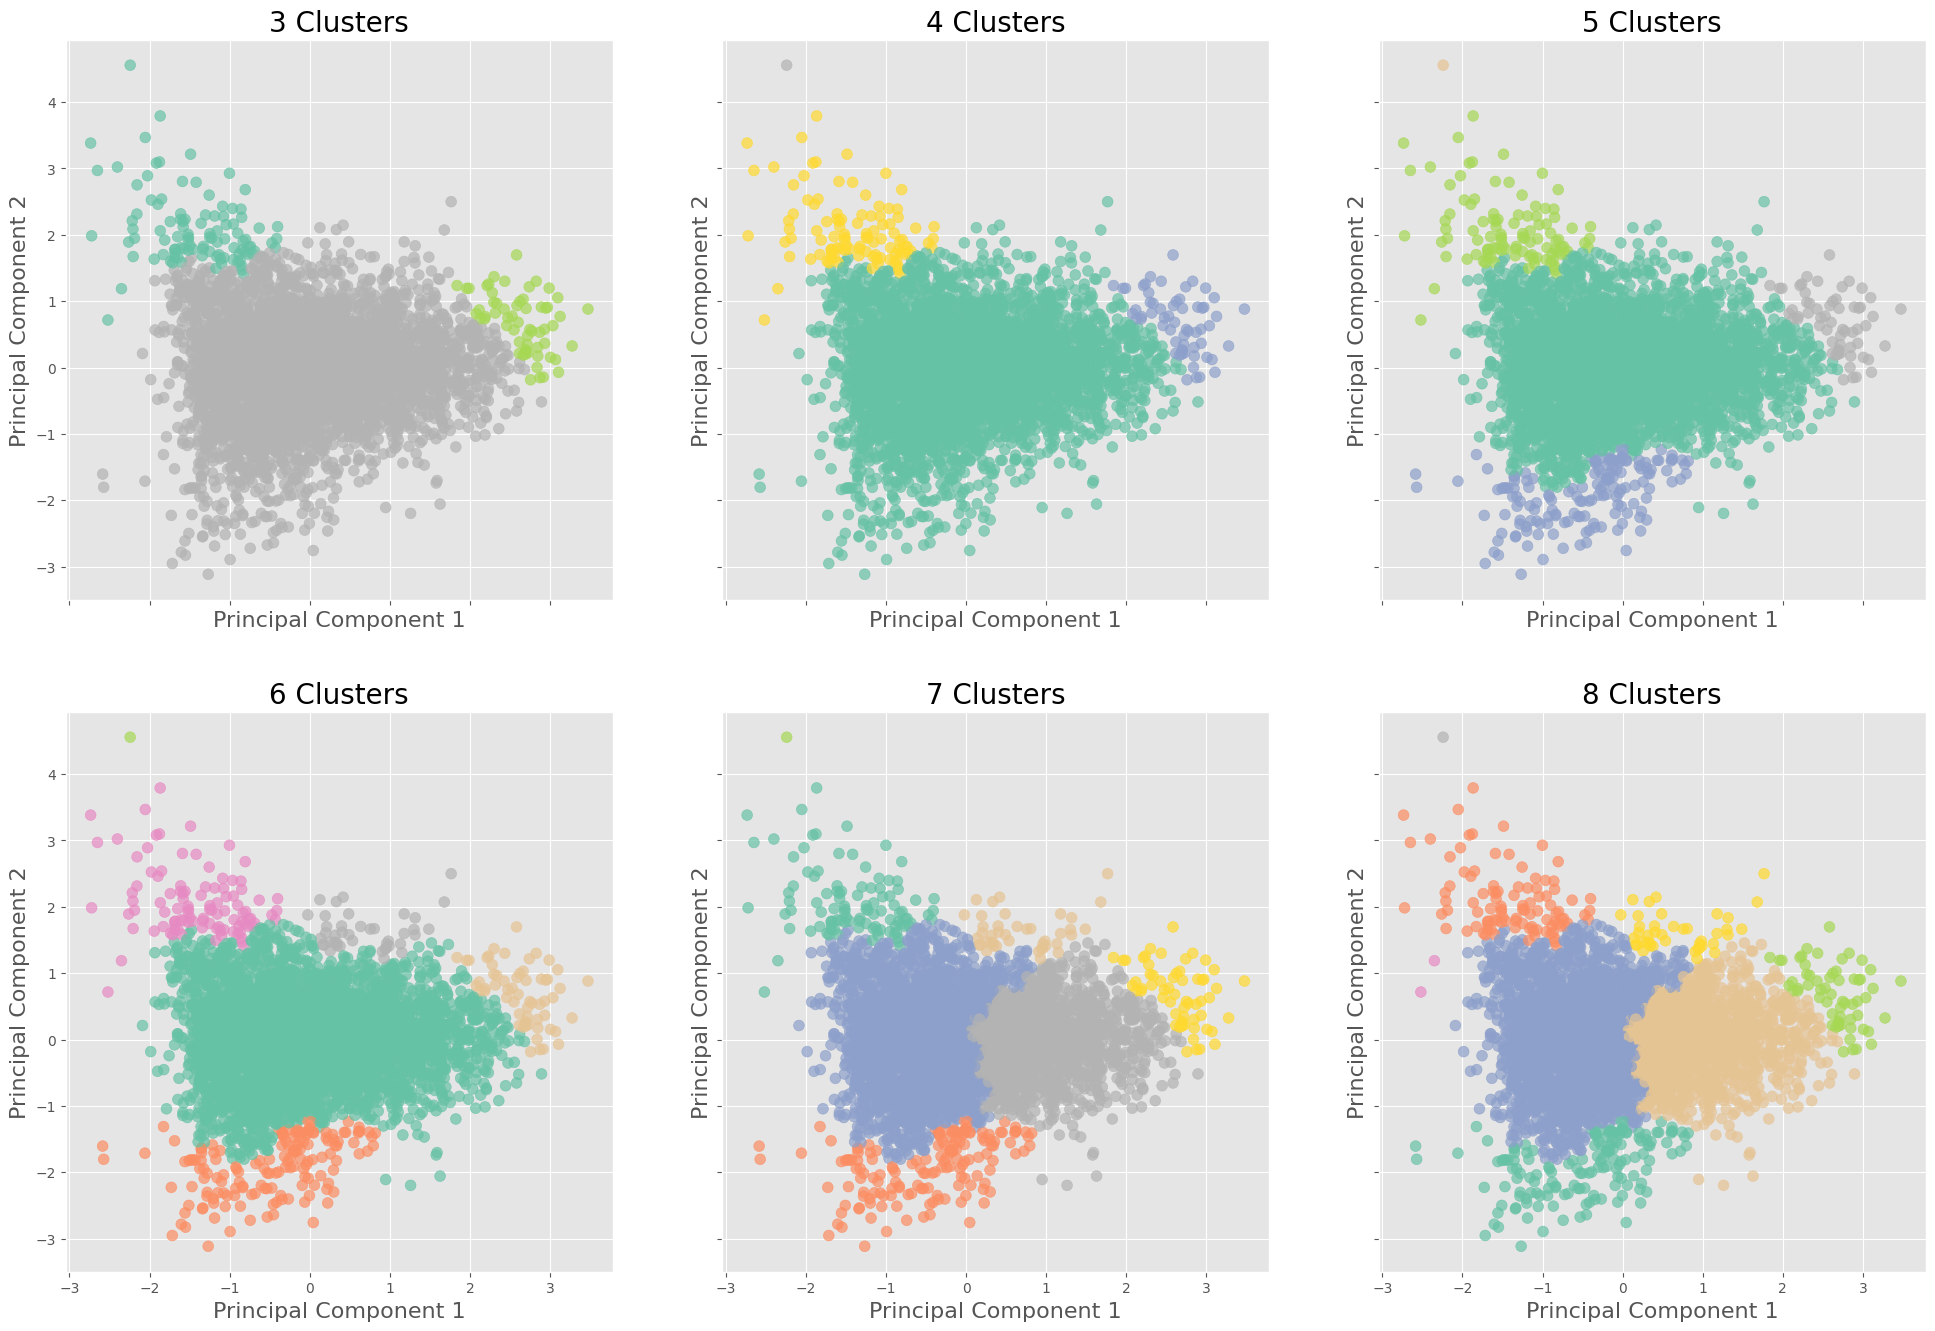

In [84]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16), sharex=True, sharey=True)

for ax, (title, model) in zip(axes.flatten(), cluster_models.items()):

    labels = model.fit_predict(X_pca_cluster_2)
    
    # Plot the clusters
    ax.scatter(X_pca_cluster_2[:, 0], X_pca_cluster_2[:, 1], c=labels, cmap="Set2", alpha=0.7, s=60)
    ax.set_title(title, fontsize=20)
    ax.set_xlabel("Principal Component 1", fontsize=16)
    ax.set_ylabel("Principal Component 2", fontsize=16)
    ax.grid(True)

plt.show()

#### Analyzing the Characteristics of Each Cluster

In [85]:
cluster_2_labels = pd.DataFrame(X_pca_cluster_2, columns=["PC1", "PC2"])

for title, model in cluster_models.items():
    labels = model.fit_predict(X_pca_cluster_2)
    cluster_2_labels[title] = labels


for title in cluster_models.keys():
    print(f"\n{title} Cluster Summary:")
    summary = cluster_2_labels.groupby(title).agg({
        "PC1": ["mean", "std", "min", "max", "count"],
        "PC2": ["mean", "std", "min", "max", "count"]
    })
    display(summary)


3 Clusters Cluster Summary:


PC1                                           PC2            \
                mean       std       min       max count      mean       std   
3 Clusters                                                                     
0          -1.417911  0.546893 -2.735386 -0.400880   104  2.083531  0.559390   
1           2.641549  0.344113  1.839586  3.474019    61  0.687415  0.436333   
2          -0.003344  0.924752 -2.585070  2.893926  4089 -0.063248  0.761659   

                                      
                 min       max count  
3 Clusters                            
0           0.717126  4.556248   104  
1          -0.183141  1.697724    61  
2          -3.113140  2.499751  4089


4 Clusters Cluster Summary:


PC1                                           PC2            \
                mean       std       min       max count      mean       std   
4 Clusters                                                                     
0          -0.003344  0.924752 -2.585070  2.893926  4089 -0.063248  0.761659   
1           2.641549  0.344113  1.839586  3.474019    61  0.687415  0.436333   
2          -1.409915  0.543425 -2.735386 -0.400880   103  2.059524  0.505429   
3          -2.241444       NaN -2.241444 -2.241444     1  4.556248       NaN   

                                      
                 min       max count  
4 Clusters                            
0          -3.113140  2.499751  4089  
1          -0.183141  1.697724    61  
2           0.717126  3.791299   103  
3           4.556248  4.556248     1


5 Clusters Cluster Summary:


PC1                                           PC2            \
                mean       std       min       max count      mean       std   
5 Clusters                                                                     
0           0.015961  0.927049 -2.088041  2.893926  3932  0.010207  0.674819   
1          -0.486829  0.713310 -2.585070  0.818717   157 -1.902892  0.430363   
2          -1.409915  0.543425 -2.735386 -0.400880   103  2.059524  0.505429   
3          -2.241444       NaN -2.241444 -2.241444     1  4.556248       NaN   
4           2.641549  0.344113  1.839586  3.474019    61  0.687415  0.436333   

                                      
                 min       max count  
5 Clusters                            
0          -2.195651  2.499751  3932  
1          -3.113140 -1.220322   157  
2           0.717126  3.791299   103  
3           4.556248  4.556248     1  
4          -0.183141  1.697724    61


6 Clusters Cluster Summary:


PC1                                           PC2            \
                mean       std       min       max count      mean       std   
6 Clusters                                                                     
0           0.008724  0.928135 -2.088041  2.893926  3890 -0.007273  0.656443   
1          -0.486829  0.713310 -2.585070  0.818717   157 -1.902892  0.430363   
2          -1.409915  0.543425 -2.735386 -0.400880   103  2.059524  0.505429   
3          -2.241444       NaN -2.241444 -2.241444     1  4.556248       NaN   
4           2.641549  0.344113  1.839586  3.474019    61  0.687415  0.436333   
5           0.686279  0.473310 -0.023654  1.765668    42  1.629203  0.269951   

                                      
                 min       max count  
6 Clusters                            
0          -2.195651  1.732800  3890  
1          -3.113140 -1.220322   157  
2           0.717126  3.791299   103  
3           4.556248  4.556248     1  
4          -0.183141  1.697724    61  
5           1.221634  2.499751    42


7 Clusters Cluster Summary:


PC1                                           PC2            \
                mean       std       min       max count      mean       std   
7 Clusters                                                                     
0          -1.409915  0.543425 -2.735386 -0.400880   103  2.059524  0.505429   
1          -0.486829  0.713310 -2.585070  0.818717   157 -1.902892  0.430363   
2          -0.593727  0.503537 -2.088041  0.817516  2394  0.007265  0.736191   
3          -2.241444       NaN -2.241444 -2.241444     1  4.556248       NaN   
4           2.641549  0.344113  1.839586  3.474019    61  0.687415  0.436333   
5           0.686279  0.473310 -0.023654  1.765668    42  1.629203  0.269951   
6           0.972807  0.568995  0.047975  2.893926  1496 -0.030537  0.502550   

                                      
                 min       max count  
7 Clusters                            
0           0.717126  3.791299   103  
1          -3.113140 -1.220322   157  
2          -1.800762  1.732800  2394  
3           4.556248  4.556248     1  
4          -0.183141  1.697724    61  
5           1.221634  2.499751    42  
6          -2.195651  1.456188  1496


8 Clusters Cluster Summary:


PC1                                           PC2            \
                mean       std       min       max count      mean       std   
8 Clusters                                                                     
0          -0.486829  0.713310 -2.585070  0.818717   157 -1.902892  0.430363   
1          -1.389613  0.528804 -2.735386 -0.400880   101  2.081434  0.484236   
2          -0.593727  0.503537 -2.088041  0.817516  2394  0.007265  0.736191   
3          -2.435202  0.119566 -2.519748 -2.350655     2  0.953080  0.333690   
4           2.641549  0.344113  1.839586  3.474019    61  0.687415  0.436333   
5           0.686279  0.473310 -0.023654  1.765668    42  1.629203  0.269951   
6           0.972807  0.568995  0.047975  2.893926  1496 -0.030537  0.502550   
7          -2.241444       NaN -2.241444 -2.241444     1  4.556248       NaN   

                                      
                 min       max count  
8 Clusters                            
0          -3.113140 -1.220322   157  
1           1.410126  3.791299   101  
2          -1.800762  1.732800  2394  
3           0.717126  1.189034     2  
4          -0.183141  1.697724    61  
5           1.221634  2.499751    42  
6          -2.195651  1.456188  1496  
7           4.556248  4.556248     1

As the number of clusters increases from 3 to 8, several small clusters emerge, some of which contain only a single point or very few observations, indicating potential outliers. The larger, dense clusters tend to remain stable across different configurations, suggesting that the core structure of the data is well-represented even with fewer clusters. However, the presence of these smaller clusters indicates that the data contains several niche groups, which may require more precise segmentation or outlier removal to improve overall clustering quality.

#### DBSCAN on Cluster 2

#### Finding the Optimal eps with k-Distance Graph

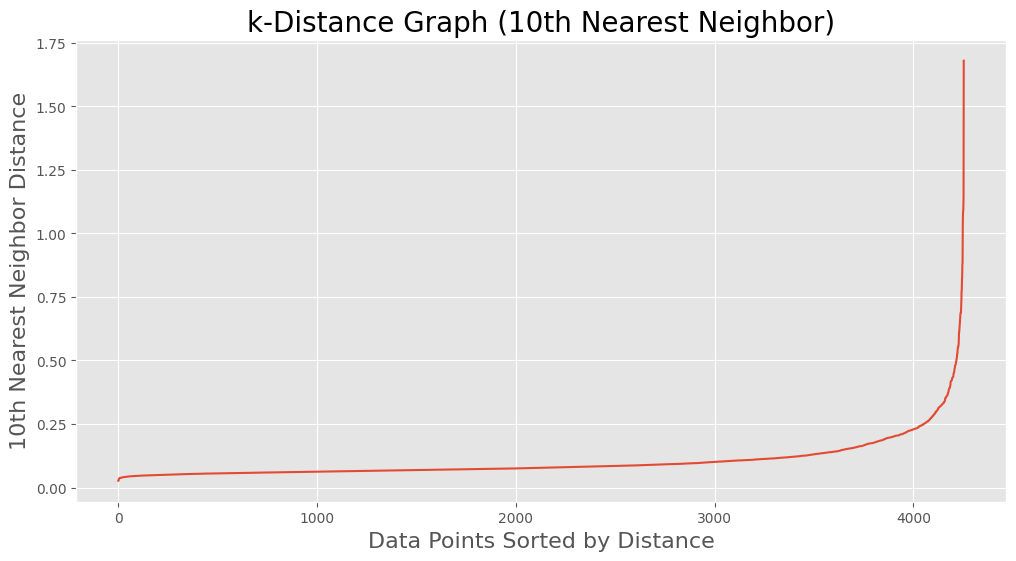

In [86]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_pca_cluster_2)
distances, indices = neighbors_fit.kneighbors(X_pca_cluster_2)

distances = np.sort(distances[:, 9])  # 10th nearest neighbor distance
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.title("k-Distance Graph (10th Nearest Neighbor)", fontsize=20)
plt.xlabel("Data Points Sorted by Distance", fontsize=16)
plt.ylabel("10th Nearest Neighbor Distance", fontsize=16)
plt.grid(True)
plt.show()

We can see a sharp increase starting around 0.5 to 1.2, indicating a potential eps value within this range.

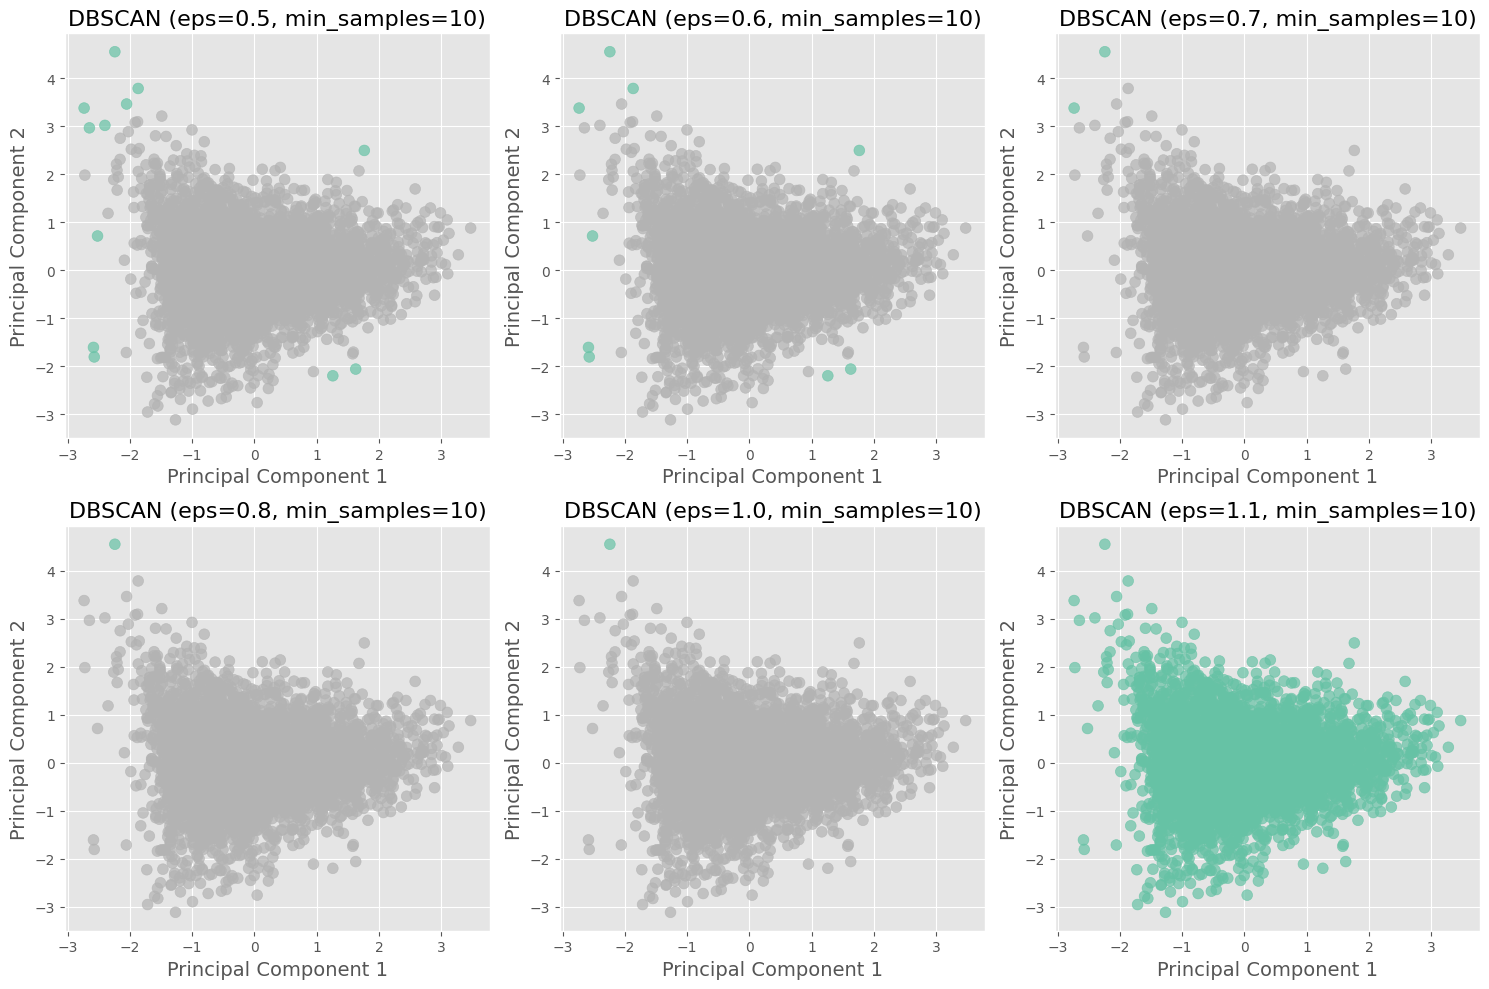

In [102]:
eps_values = [0.5, 0.6, 0.7, 0.8, 1.0, 1.1]
min_samples = 10

plt.figure(figsize=(15, 10))

for i, eps in enumerate(eps_values, 1):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_pca_cluster_2)
    
    plt.subplot(2, 3, i)
    plt.scatter(X_pca_cluster_2[:, 0], X_pca_cluster_2[:, 1], c=labels, cmap="Set2", alpha=0.7, s=60)
    plt.title(f"DBSCAN (eps={eps}, min_samples={min_samples})", fontsize=16)
    plt.xlabel("Principal Component 1", fontsize=14)
    plt.ylabel("Principal Component 2", fontsize=14)
    plt.grid(True)

plt.tight_layout()
plt.show()

The DBSCAN clustering approach was tested with various epsilon values ranging from 0.5 to 1.1, revealing that the algorithm struggles to identify meaningful clusters within this dataset. At lower epsilon values, only a few sparse points are identified as clusters, while at higher values (eps=1.1), the entire dataset is classified as a single dense cluster. This indicates that the structure within this dataset may not be well-suited for DBSCAN, potentially due to the high density and compact distribution of the majority of the data points after PCA.

### 7. KMeans Clustering

In [104]:
# !pip install kneed

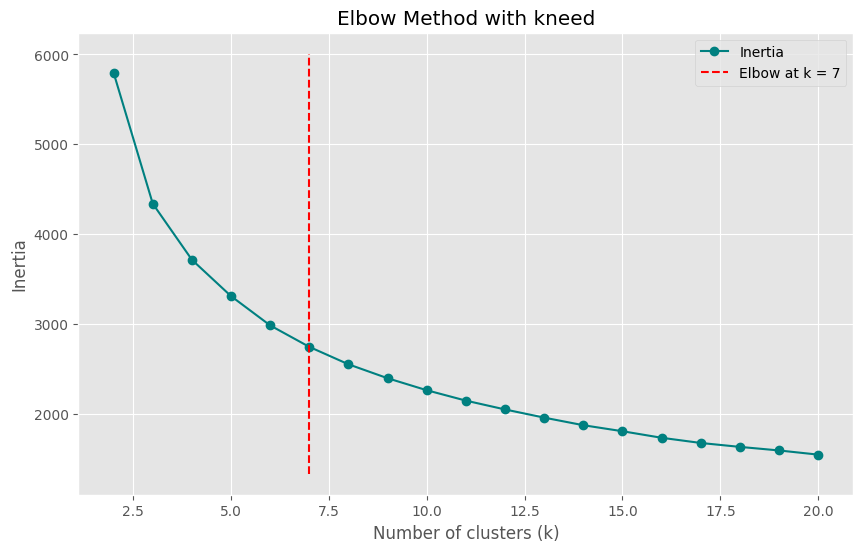

Optimal number of clusters (k): 7


In [105]:
from kneed import KneeLocator

inertia = []
k_values = range(2, 21)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_df_robust)
    inertia.append(kmeans.inertia_)

knee = KneeLocator(k_values, inertia, curve="convex", direction="decreasing")

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o',color="teal", label="Inertia")
plt.vlines(knee.knee, plt.ylim()[0], plt.ylim()[1], linestyles="--", colors='red', label=f"Elbow at k = {knee.knee}")
plt.title("Elbow Method with kneed")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal number of clusters (k): {knee.knee}")

In [106]:
kmeans = KMeans(n_clusters=knee.knee, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_df_robust)

final_df["cluster_kmeans"] = kmeans_labels

In [107]:
final_df

,TotalSpent,Frequency,Recency,AvgUnitPrice,cluster_kmeans
CustomerID,,,,,
12347.0,4060.40,7,2,2.652873,4
12348.0,835.08,4,75,0.877500,6
12349.0,1417.60,1,19,3.734507,1
12350.0,294.40,1,310,1.581250,6
12352.0,1125.28,5,36,4.496452,5
...,...,...,...,...,...
18280.0,180.60,1,278,4.765000,3
18281.0,46.92,1,181,1.092000,6
18282.0,176.60,2,8,5.199167,1


In [108]:
final_df["cluster_kmeans"] = final_df["cluster_kmeans"] + 1

In [109]:
final_df

,TotalSpent,Frequency,Recency,AvgUnitPrice,cluster_kmeans
CustomerID,,,,,
12347.0,4060.40,7,2,2.652873,5
12348.0,835.08,4,75,0.877500,7
12349.0,1417.60,1,19,3.734507,2
12350.0,294.40,1,310,1.581250,7
12352.0,1125.28,5,36,4.496452,6
...,...,...,...,...,...
18280.0,180.60,1,278,4.765000,4
18281.0,46.92,1,181,1.092000,7
18282.0,176.60,2,8,5.199167,2


In [110]:
final_df.groupby("cluster_kmeans").describe()

TotalSpent                                                \
                    count         mean           std     min        25%   
cluster_kmeans                                                            
1                   925.0   394.228250    271.086521   15.00   203.9500   
2                   476.0   554.873550    346.351101   35.40   321.5025   
3                   666.0  1547.348305    921.362937  294.25   906.1700   
4                   409.0   329.510247    291.518870    4.95   133.0600   
5                   501.0  7251.868285  12482.097632  900.47  2867.1100   
6                   662.0  1726.820485   1135.890310  343.45   971.8475   
7                   635.0   287.434866    206.128966    2.90   144.5300   

                                             Frequency             ...  \
                     50%      75%        max     count       mean  ...   
cluster_kmeans                                                     ...   
1                324.240   511.32    1945.68     925.0   1.459459  ...   
2                502.520   700.25    2860.71     476.0   2.258403  ...   
3               1318.655  1905.10    5982.84     666.0   4.564565  ...   
4                268.580   430.50    2661.24     409.0   1.435208  ...   
5               4314.890  6765.70  189011.48     501.0  15.816367  ...   
6               1437.005  2169.67   10290.78     662.0   4.537764  ...   
7                241.060   366.02    1775.24     635.0   1.400000  ...   

               Recency        AvgUnitPrice                                \
                   75%    max        count      mean       std       min   
cluster_kmeans                                                             
1               260.00  374.0        925.0  3.038921  0.552206  1.877647   
2                22.00   45.0        476.0  3.158500  0.784326  1.684915   
3                56.75  302.0        666.0  2.125737  0.413615  0.671795   
4               278.00  374.0        409.0  6.004172  1.998228  4.125000   
5                15.00  372.0        501.0  2.929825  0.805276  1.399615   
6                80.75  366.0        662.0  3.730762  0.753570  2.590930   
7               184.50  374.0        635.0  1.589544  0.448237  0.290000   

                                                         
                     25%       50%       75%        max  
cluster_kmeans                                           
1               2.596897  2.972857  3.450000   4.316190  
2               2.650183  2.998442  3.534011   7.336667  
3               1.860681  2.174176  2.431411   2.978333  
4               4.829750  5.441250  6.527931  23.475000  
5               2.397682  2.837003  3.319931   8.131581  
6               3.159163  3.591119  4.171673   7.476400  
7               1.297634  1.685000  1.938789   2.388800  

[7 rows x 32 columns]

In [111]:
features = ["TotalSpent", "Frequency", "Recency", "AvgUnitPrice"]
cluster_kmeans_summary = final_df.groupby("cluster_kmeans")[features].mean().round(2)
display(cluster_kmeans_summary)

,TotalSpent,Frequency,Recency,AvgUnitPrice
cluster_kmeans,,,,
1,394.23,1.46,176.36,3.04
2,554.87,2.26,14.49,3.16
3,1547.35,4.56,40.84,2.13
4,329.51,1.44,188.90,6.00
5,7251.87,15.82,10.84,2.93
6,1726.82,4.54,63.10,3.73
7,287.43,1.40,119.02,1.59


In [112]:
final_df['cluster_kmeans'].value_counts().sort_index()

cluster_kmeans
1    925
2    476
3    666
4    409
5    501
6    662
7    635
Name: count, dtype: int64

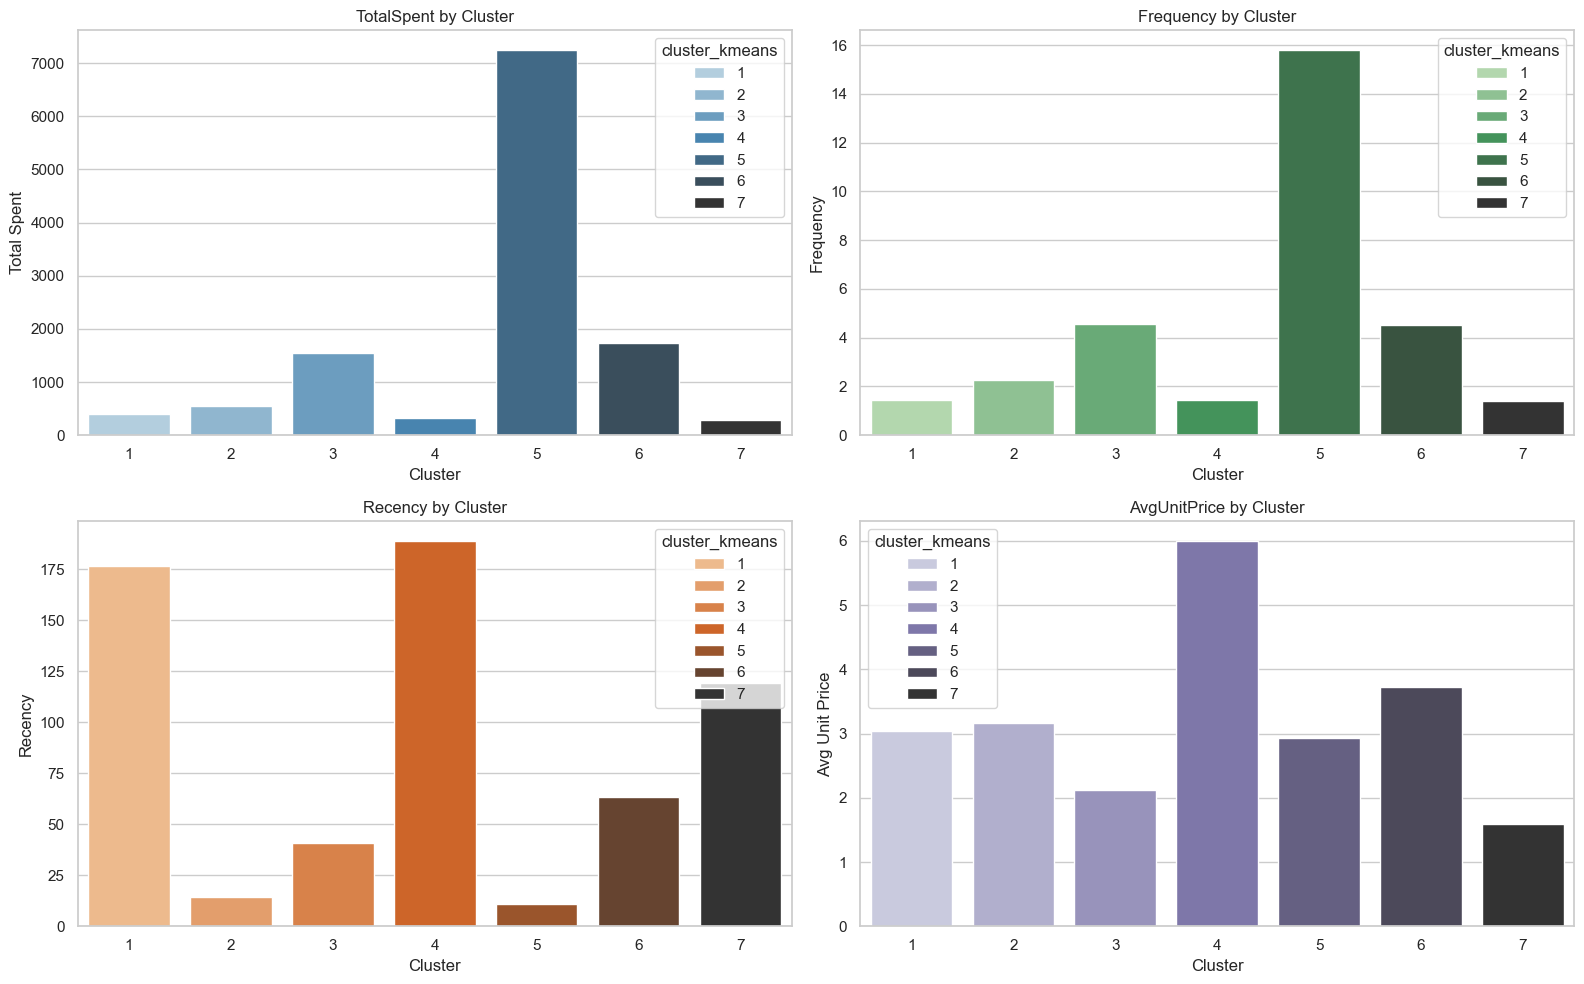

In [113]:
kmeans_cluster_df = final_df.groupby("cluster_kmeans")[features].mean().reset_index()

sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# TotalSpent
sns.barplot(data=kmeans_cluster_df, x="cluster_kmeans", y="TotalSpent", hue="cluster_kmeans", ax=axes[0, 0], palette="Blues_d")
axes[0, 0].set_title("TotalSpent by Cluster")
axes[0, 0].set_xlabel("Cluster")
axes[0, 0].set_ylabel("Total Spent")

# Frequency
sns.barplot(data=kmeans_cluster_df, x="cluster_kmeans", y="Frequency", hue="cluster_kmeans", ax=axes[0, 1], palette="Greens_d")
axes[0, 1].set_title("Frequency by Cluster")
axes[0, 1].set_xlabel("Cluster")
axes[0, 1].set_ylabel("Frequency")

# Recency
sns.barplot(data=kmeans_cluster_df, x="cluster_kmeans", y="Recency", hue="cluster_kmeans", ax=axes[1, 0], palette="Oranges_d")
axes[1, 0].set_title("Recency by Cluster")
axes[1, 0].set_xlabel("Cluster")
axes[1, 0].set_ylabel("Recency")

# AvgUnitPrice
sns.barplot(data=kmeans_cluster_df, x="cluster_kmeans", y="AvgUnitPrice", hue="cluster_kmeans", ax=axes[1, 1], palette="Purples_d")
axes[1, 1].set_title("AvgUnitPrice by Cluster")
axes[1, 1].set_xlabel("Cluster")
axes[1, 1].set_ylabel("Avg Unit Price")

plt.tight_layout()
plt.show()

### What Can We Learn From These Clusters? (KMeans Clustering)

Each customer cluster reveals distinct behavioral patterns based on four key features: **TotalSpent**, **Frequency**, **Recency**, and **AvgUnitPrice**. Here's what we can infer:

- **Cluster 1**: **Small and inactive spenders**  
  Customers in this cluster have the lowest **TotalSpent (~394)** and low purchase **Frequency (~1.46)**, but a high **Recency (~176)**, indicating long periods without purchases.  
  These might be **low-engagement or churned** customers.

- **Cluster 2**: **Moderate spenders with moderate activity**  
  These customers spend **moderately (~554)**, shop **more often (~2.26)**, and have a very short **Recency (~14)**, suggesting they are **recently active** but not highly frequent buyers.  
  Potential candidates for **engagement campaigns**.

- **Cluster 3**: **Frequent, mid-tier buyers**  
  Customers in this cluster have a higher **TotalSpent (~1547)**, a relatively high **Frequency (~4.56)**, and moderate **Recency (~41)**.  
  They could be **consistent buyers** with potential for loyalty programs.

- **Cluster 4**: **High Recency, low frequency**  
  These customers have the lowest **Frequency (~1.44)** and the highest **Recency (~189)**, indicating **dormant or infrequent buyers**.  
  Likely require **reactivation efforts**.

- **Cluster 5**: **Top-tier loyal customers**  
  This group has the **highest TotalSpent (~7251)**, **highest Frequency (~15.82)**, and very short **Recency (~11)**, representing **high-value, frequent buyers**.  
  Strategic group for **VIP treatment and retention campaigns**.

- **Cluster 6**: **High spenders with moderate frequency**  
  These customers spend **significantly (~1726)**, with **moderate Frequency (~4.54)** and short **Recency (~63)**.  
  Potential for **up-sell and cross-sell** strategies.

- **Cluster 7**: **Low spenders, inactive**  
  Customers in this group have the **lowest TotalSpent (~287)**, **lowest Frequency (~1.40)**, and relatively long **Recency (~119)**, indicating **low engagement**.  
  Likely candidates for **win-back campaigns**.


### 8. Interpretation and Insights

Here are the key takeaways:

- **KMeans Outperformed Other Methods:**  
  - **Optimal k:** Using the **Elbow Method** with **KneeLocator**, the optimal number of clusters was clearly identified, resulting in compact, well-separated clusters.  
  - **Stable and Consistent Results:** Unlike Agglomerative Clustering and DBSCAN, **KMeans** consistently produced stable clusters, making it the most effective method for this dataset.  
  - **High Inertia Reduction:** The elbow method showed a significant drop in inertia, confirming that the chosen cluster count captures the majority of variance without overfitting.  

- **Agglomerative Clustering with PCA Refinement:**  
  - **Initial Segmentation:** Although initial results from Agglomerative Clustering were mixed, applying **PCA** to one of the larger, more complex clusters significantly improved segmentation quality.  
  - **Natural Sub-Clusters:** The PCA-transformed cluster revealed clear sub-clusters, with stable results observed for **3 to 8 clusters**, indicating a meaningful segmentation within this subset.  
  - **Improved Compactness:** The use of PCA reduced noise and better captured the underlying structure of customer behaviors within this challenging cluster.  

- **DBSCAN Limitations:**  
  - **Parameter Sensitivity:** Required careful tuning of `eps` and `min_samples`, but still produced a high number of noise points, reducing overall cluster quality.  
  - **High Dimensional Complexity:** Struggled to handle the complex, overlapping structure of the customer data, leading to fragmented clusters.  